## requirements
* tensorflow
* adjustText (pip install adjustText)

In [258]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [4]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import faiss
import h5py, torch
from torchbiggraph.model import ComplexDiagonalDynamicOperator, DotComparator, CosComparator
import json
from utility import kgtk_to_dataframe
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorboard.plugins import projector
from adjustText import adjust_text
import glob

In [5]:
work_dir = "./output/wikidata-20210215-dwd"
store_dir = "./output/wikidata-20210215-dwd/temp-surprise"
# item_file = "./data/wikidata-20210215-dwd/claims.wikibase-item.tsv.gz"
label_file = "./data/wikidata-20210215-dwd/labels.en.tsv.gz"
# pagerank_file = "./data/wikidata-20210215-dwd/metadata.pagerank.directed.tsv.gz"
descriptions_file = "./data/wikidata-20210215-dwd/descriptions.en.tsv.gz"

# embedding_files = {
#                    "Profile-ComplEx" : "./output/wikidata-20210215-dwd/profile_graph_embeddings/profile_graph_embeddings.ComplEx.tsv",
#                    "Profile-TransE" : "./output/wikidata-20210215-dwd/profile_graph_embeddings/profile_graph_embeddings.TransE.tsv"
#                   }

complex_dir = "/data02/profiling/wikidata-20210215-dwd-v2.complex-embeddings"
vector_dimension = 100

complex_faiss_file = "/data02/profiling/complex_embeddings/wikidataos.v2.20211114.complex.index.idx"
complex_faiss_id2node_file = "/data02/profiling/complex_embeddings/wikidataos.v2.20211114.complex.index_to_qnode.test.tsv"

### Process params / set up variables

In [6]:
# Ensure paths are absolute
work_dir = os.path.abspath(work_dir)
# store_dir = os.path.abspath(store_dir)
# item_file = os.path.abspath(item_file)
label_file = os.path.abspath(label_file)
descriptions_file = os.path.abspath(descriptions_file)
# for name, file_path in embedding_files.items():
#     embedding_files[name] = os.path.abspath(file_path)

# profile_graph_dir = "{}/label_formatting".format(work_dir)
    
# Create directories
output_dir = "{}/surprise_prediction".format(work_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(store_dir):
    os.makedirs(store_dir)
    
# adding some environment variables we'll be using frequently
os.environ['STORE'] = "{}/wikidata.sqlite3.db".format(store_dir)
# os.environ['OUT'] = output_dir
# os.environ['PGRAPH'] = profile_graph_dir
os.environ['LABELS'] = label_file

Load profile labels (reusing some work already done by another notebook here -- fun_fact_exploration)

In [7]:
profile_labels_df = pd.read_csv(f"{work_dir}/explainability/profile_labels_info_joined.RELs_and_AILs.tsv", sep='\t', dtype=str).fillna("")

In [8]:
label_distinctiveness_df = pd.read_csv(f"{work_dir}/explainability/profile_labels.RELs_and_AILs.distinctiveness.tsv", sep='\t')
label_distinctiveness_dict = dict(zip(label_distinctiveness_df.node1, label_distinctiveness_df.node2))

distinctivenesses = []
for _, row in tqdm(profile_labels_df.iterrows(), total=len(profile_labels_df)):
    label = row["id"]
    distinctivenesses.append(label_distinctiveness_dict[label])
profile_labels_df["distinctiveness"] = distinctivenesses

100%|████████████████████████████████████████████████████████████████████████████| 621114/621114 [00:29<00:00, 20931.31it/s]


In [9]:
labels_en_df = pd.read_csv(label_file, sep='\t')

In [10]:
labels_en_dict = dict(zip(labels_en_df.node1, labels_en_df.node2))

In [11]:
descriptions_df = pd.read_csv(descriptions_file, sep='\t')

In [12]:
descriptions_dict = dict(zip(descriptions_df.node1, descriptions_df.node2))

In [13]:
def remove_lang_tag(label):
    return label[1:-4]

In [14]:
# Note this code assumes we are only using AILs and RELs
plab_labels = []
for _, row in tqdm(profile_labels_df.iterrows(), total=len(profile_labels_df)):
    type_label = remove_lang_tag(row["type_label"])
    property_label = remove_lang_tag(row["property_label"])
    if row["node2"] != "":
        if row["node2"] in labels_en_dict:
            value_label = remove_lang_tag(labels_en_dict[row["node2"]])
        else:
            value_label = row["node2"]
    else:
        lb = row["lower_bound"]
        ub = row["upper_bound"]
        value_label = f"{lb}-{ub}"
        si = row["si_units"]
        wd = row["wd_units"]
        if wd != "":
            if wd in labels_en_dict:
                wd = remove_lang_tag(labels_en_dict[wd])
            value_label = value_label + f" {wd}"
        elif si != "":
            value_label = value_label + f" {si}"
    plab_labels.append(f"{type_label}, {property_label}, {value_label}")
profile_labels_df["plab_label"] = plab_labels

100%|████████████████████████████████████████████████████████████████████████████| 621114/621114 [00:39<00:00, 15675.53it/s]


In [15]:
# Trim profile_labels_df to just columns we need
profile_labels_df = profile_labels_df.loc[:,["id", "plab_label", "support", "distinctiveness"]]

set up dictionaries for profile-label to entities and vice-versa to speed things up. Just doing this for humans for now to limit memory usage.

also why does {work_dir} get messed up in below kypher cell

In [19]:
%%time
res = !kgtk query -i /data02/profiling/kgtk/entity_profiling/output/wikidata-20210215-dwd/explainability/entity_profile_labels.RELs_and_AILs.shuffled.tsv --graph-cache $STORE \
    --match 'profile_labels: (ent)-[]->(profile_label_id)' \
    --return 'ent as entity, profile_label_id as profile_label_id' \
    --where 'printf("%.2s", profile_label_id) = "Q5"'
human_ents_to_labels_df = kgtk_to_dataframe(res)

CPU times: user 1min 21s, sys: 17.4 s, total: 1min 38s
Wall time: 2min 40s


In [20]:
human_ent_to_labels_dict = {}
human_label_to_ents_dict = {}
for _, row in (tqdm(human_ents_to_labels_df.iterrows(), total=len(human_ents_to_labels_df))):
    ent = row["entity"]
    profile_label_id = row["profile_label_id"]
    
    if ent not in human_ent_to_labels_dict:
        human_ent_to_labels_dict[ent] = []
    human_ent_to_labels_dict[ent].append(profile_label_id)
    
    if profile_label_id not in human_label_to_ents_dict:
        human_label_to_ents_dict[profile_label_id] = []
    human_label_to_ents_dict[profile_label_id].append(ent)

100%|████████████████████████████████████████████████████████████████████████| 32605756/32605756 [31:02<00:00, 17509.85it/s]


## Trying out link prediction...

In [11]:
rel_index["P31"]

25

In [38]:
with h5py.File(f"{complex_dir}/model/model.v600.h5", "r") as hf:
    print(hf["model/relations/0/operator"].keys())

<KeysViewHDF5 ['lhs', 'rhs']>


In [169]:
%%time
print("loading relation names...")
relation_names_list = json.load(open(f"{complex_dir}/dynamic_rel_names.json"))
print("loading entity names...")
entity_names_list = json.load(open(f"{complex_dir}/entity_names_all_0.json"))
prop_count = len(relation_names_list)

# operators
print("setting up operators...")
operator_lhs = ComplexDiagonalDynamicOperator(vector_dimension, prop_count)
operator_rhs = ComplexDiagonalDynamicOperator(vector_dimension, prop_count)
comparator = DotComparator()
cos_comparator = CosComparator()
with h5py.File(f"{complex_dir}/model/model.v600.h5", "r") as hf:
    operator_state_dict_lhs = {
        "real": torch.from_numpy(hf["model/relations/0/operator/lhs/real"][...]),
        "imag": torch.from_numpy(hf["model/relations/0/operator/lhs/imag"][...]),
    }
    operator_state_dict_rhs = {
        "real": torch.from_numpy(hf["model/relations/0/operator/rhs/real"][...]),
        "imag": torch.from_numpy(hf["model/relations/0/operator/rhs/imag"][...]),
    }

print("loading operator state...")
operator_lhs.load_state_dict(operator_state_dict_lhs)
operator_rhs.load_state_dict(operator_state_dict_rhs)

# Load the embeddings
print("loading all embeddings...")
with h5py.File(f"{complex_dir}/model/embeddings_all_0.v600.h5", "r") as hf:
    embeddings = torch.from_numpy(hf["embeddings"][...])


print("creating entity-to-index dict...")
entity_to_index = {}
for i, entity in enumerate(entity_names_list):
    entity_to_index[entity] = i
    

print("creating relation-to-index dict...")
rel_index = {}
for i, rel in enumerate(relation_names_list):
    rel_index[rel] = i

loading relation names...
loading entity names...
setting up operators...
loading operator state...
loading all embeddings...
creating entity-to-index dict...
creating relation-to-index dict...
CPU times: user 39.6 s, sys: 27.4 s, total: 1min 6s
Wall time: 59.3 s


In [14]:
def get_embed(head, relation=None):
    ''' This function generate the embeddings for the tail entities:
            Head entities: Obtained from the model
            Head + relation: Obtained using torch
        :param head: subject Qnode
        :param relation: optional property
    '''
    if relation is None:
        return embeddings[entity_to_index[head], :].detach().numpy()
    return  operator_lhs(
                embeddings[entity_to_index[head], :].view(1, vector_dimension),
                torch.tensor([rel_index[relation]])
            ).detach().numpy()[0]

Load Faiss index

In [24]:
%time index = faiss.read_index(complex_faiss_file)

CPU times: user 1.91 s, sys: 27.7 s, total: 29.7 s
Wall time: 1min 17s


Should just be able to load file, but for now I haven't created the full id2node file, so using workaround

In [25]:
index_to_entity = {i : e for e, i in tqdm(entity_to_index.items())}

100%|██████████████████████████████████████████████████████████████████| 53002670/53002670 [00:20<00:00, 2544369.21it/s]


Try out link prediction

In [45]:
dists, idxs = index.search(get_embed("Q2685", "P31")[np.newaxis,:], 10)
for i in range(len(idxs[0])):
    dist = dists[0][i]
    idx = idxs[0][i]
    entity = index_to_entity[idx]
    print(f"{idx}--{entity}--{labels_en_dict[entity] if entity in labels_en_dict else ''} ({dist})")

24025787--Q24865--'medium-length film'@en (876.6491088867188)
4095802--Q101086895--'Quake 4: Special DVD Edition'@en (878.5010986328125)
40290602--Q98349748--'Manhunt video game poster'@en (879.8681030273438)
25831292--Q22908356--'RocksDB'@en (880.2685546875)
16884844--Q940526--'Lightweight Java Game Library'@en (884.8045654296875)
44427695--Q329709--'Mutiny on the Bounty'@en (886.592529296875)
21257676--Q100975207--'Panty & Stocking with Garterbelt, season 1'@en (886.7252807617188)
30748454--Q16989070--'Killing Floor 2'@en (886.7904052734375)
38479480--Q2586958--'Sample People'@en (887.4232177734375)
15695740--Q852170--'dredging'@en (887.6710205078125)


We'd expect cosine similarity with expected answer to be relatively high... Something seems wrong here

In [41]:
cosine_similarity(get_embed("Q2685", "P31")[None,:], embeddings[entity_to_index["Q5"]][None,:])

array([[0.04115853]], dtype=float32)

In [43]:
cosine_similarity(embeddings[entity_to_index["Q7380"]][None,:], embeddings[entity_to_index["Q5"]][None,:])

array([[0.09341093]], dtype=float32)

the faiss index we loaded uses L2 distance, not cosine sim, so let's see if the cosine sim of returned ent is at least higher

In [44]:
cosine_similarity(get_embed("Q7747", "P31")[None,:], embeddings[45784517][None,:])

array([[0.22770156]], dtype=float32)

checking faiss index is not the problem

In [68]:
dists, idxs = index.search(get_embed("Q7747")[np.newaxis,:], 10)
for i in range(len(idxs[0])):
    dist = dists[0][i]
    idx = idxs[0][i]
    entity = index_to_entity[idx]
    print(f"{idx}--{entity}--{labels_en_dict[entity] if entity in labels_en_dict else ''} ({dist})")

30177150--Q7747--'Vladimir Putin'@en (0.0)
40766300--Q24010709--'Dalay Gungayev'@en (5.15888786315918)
43416411--Q50666204-- (5.282342910766602)
34733566--Q4506127--'Gennady Tsukanov'@en (5.303508281707764)
11663212--Q3655407--'Maxim Martsinkevich'@en (5.322127819061279)
15331800--Q25390329-- (5.448688507080078)
39684859--Q28355282-- (5.457427024841309)
44334288--Q42716965--'Valery Sdobnyakov'@en (5.460710525512695)
49332696--Q15074568-- (5.480818748474121)
15517254--Q4080549--'Iosif Begun'@en (5.482292175292969)


In [202]:
dists, idxs = index.search(get_embed("Q41")[np.newaxis,:], 10)
for i in range(len(idxs[0])):
    dist = dists[0][i]
    idx = idxs[0][i]
    entity = index_to_entity[idx]
    print(f"{idx}--{entity}--{labels_en_dict[entity] if entity in labels_en_dict else ''} ({dist})")

20883939--Q41--'Greece'@en (2.168404344971009e-19)
46548683--Q902--'Bangladesh'@en (6.666644096374512)
25379358--Q37--'Lithuania'@en (7.628525257110596)
2786549--Q414--'Argentina'@en (8.074991226196289)
19715565--Q778--'The Bahamas'@en (8.34022331237793)
29585946--Q1014--'Liberia'@en (8.513887405395508)
20025204--Q189--'Iceland'@en (8.803410530090332)
19178706--Q423--'North Korea'@en (9.280503273010254)
24307526--Q813--'Kyrgyzstan'@en (9.375564575195312)
20264567--Q265--'Uzbekistan'@en (9.532572746276855)


In [28]:
dists, idxs = index.search(get_embed("Q5")[np.newaxis,:], 10)
for i in range(len(idxs[0])):
    dist = dists[0][i]
    idx = idxs[0][i]
    entity = index_to_entity[idx]
    print(f"{idx}--{entity}--{labels_en_dict[entity] if entity in labels_en_dict else ''} ({dist})")

46133588--Q5--'human'@en (8.029872339970767e-19)
16926446--Q96119363--'Lindsey B Turnbull'@en (4.227840423583984)
9974667--Q94845478--'Josef Maria Fritz'@en (4.56289005279541)
12990429--Q102287147--'Mowbray Marras'@en (4.7003326416015625)
7968143--Q99693098--'Martin Walsh'@en (4.85656213760376)
30774334--Q100882842--'Jeremy McKay'@en (4.873976707458496)
50040326--Q46771289--'Fábio Prezoto'@en (4.88075065612793)
21707366--Q85715984--'Jayro Amos Matovelo'@en (4.880918502807617)
17673689--Q25683356-- (4.972658157348633)
20686141--Q102405923--'Hilari Celeste Tiedeman'@en (4.9860124588012695)


In [29]:
dists, idxs = index.search(get_embed("Q2685")[np.newaxis,:], 10)
for i in range(len(idxs[0])):
    dist = dists[0][i]
    idx = idxs[0][i]
    entity = index_to_entity[idx]
    print(f"{idx}--{entity}--{labels_en_dict[entity] if entity in labels_en_dict else ''} ({dist})")

49577437--Q2685--'Arnold Schwarzenegger'@en (6.776263578034403e-20)
34809741--Q160528--'Burt Lancaster'@en (7.989549160003662)
42033936--Q104049--'Sidney Poitier'@en (8.44776725769043)
18413418--Q174311--'Christopher Reeve'@en (8.563664436340332)
41423396--Q208649--'Paul Giamatti'@en (8.598552703857422)
9994210--Q37876--'Natalie Portman'@en (8.656377792358398)
17342448--Q200768--'Dennis Quaid'@en (8.821816444396973)
25735655--Q38111--'Leonardo DiCaprio'@en (8.83055591583252)
10112044--Q36949--'Robert De Niro'@en (8.949609756469727)
33054582--Q59215--'Robert Redford'@en (8.956782341003418)


Let's try some others... or try debugging by loading embeddings another way and verifying entity_to_index is correct?

In [65]:
cosine_similarity(get_embed('Q170564', 'P161')[None,:], embeddings[entity_to_index["Q471003"]][None,:])

array([[0.01142104]], dtype=float32)

In [71]:
dists, idxs = index.search(get_embed('Q170564', 'P161')[np.newaxis,:], 10)
for i in range(len(idxs[0])):
    dist = dists[0][i]
    idx = idxs[0][i]
    entity = index_to_entity[idx]
    print(f"{idx}--{entity}--{labels_en_dict[entity] if entity in labels_en_dict else ''} ({dist})")

25831292--Q22908356--'RocksDB'@en (2984.478759765625)
15695740--Q852170--'dredging'@en (3000.803466796875)
21255963--Q284522--'wxPython'@en (3004.34912109375)
31070797--Q1102217--'Star Trek'@en (3004.3505859375)
52269576--Q94501--'Grand Theft Auto'@en (3005.2314453125)
44427695--Q329709--'Mutiny on the Bounty'@en (3009.531982421875)
4040450--Q753107--'Cavalcade'@en (3011.7880859375)
30748454--Q16989070--'Killing Floor 2'@en (3012.24365234375)
24025787--Q24865--'medium-length film'@en (3013.583984375)
40290602--Q98349748--'Manhunt video game poster'@en (3015.830078125)


In [70]:
cosine_similarity(get_embed('Q170564', 'P161')[None,:], embeddings[entity_to_index["Q22908356"]][None,:])

array([[0.23759155]], dtype=float32)

tom cruise + award received

In [39]:
dists, idxs = index.search(get_embed('Q37079', 'P166')[np.newaxis,:], 10)
for i in range(len(idxs[0])):
    dist = dists[0][i]
    idx = idxs[0][i]
    entity = index_to_entity[idx]
    print(f"{idx}--{entity}--{labels_en_dict[entity] if entity in labels_en_dict else ''} ({dist})")

13625718--Q908473--'DodgeBall: A True Underdog Story'@en (1774.8291015625)
26496205--Q272599--'All Quiet on the Western Front'@en (1780.6463623046875)
29808663--Q48673898--'Green Book'@en (1781.723388671875)
33465681--Q182254--'The Simpsons Movie'@en (1785.975830078125)
36920711--Q272036--'Wings'@en (1788.10498046875)
7649861--Q19816400--'Son of Saul'@en (1788.9735107421875)
39678872--Q20909--'The Cage'@en (1789.9989013671875)
2834533--Q478371--'Mrs. Miniver'@en (1790.325439453125)
33680892--Q32067466--'Slender Man'@en (1791.2520751953125)
40479005--Q208632--'It Happened One Night'@en (1793.1441650390625)


Testing embeddings make sense

In [46]:
cosine_similarity(embeddings[entity_to_index["Q30"]][None,:], embeddings[entity_to_index["Q16"]][None,:])

array([[0.59175646]], dtype=float32)

In [47]:
cosine_similarity(embeddings[entity_to_index["Q855"]][None,:], embeddings[entity_to_index["Q7747"]][None,:])

array([[0.68366134]], dtype=float32)

Testing consistency of link prediction

In [48]:
cosine_similarity(get_embed("Q7747", "P31")[None,:], get_embed("Q855", "P31")[None,:])

array([[0.6596888]], dtype=float32)

manually verifying that embedding lookup is correct

In [55]:
with open("/data02/profiling/complex_embeddings/wikidataos.v2.20211114.complex.embeddings.tsv", "r") as f:
    for line in tqdm(f):
        line.strip
        words = line.split('\t')
        if words[0] == "Q5":
            break

46133588it [04:45, 161325.42it/s]


In [58]:
emb = words[1:]
emb[-1].strip('\n')
emb = [np.float32(s) for s in emb]

In [63]:
torch.Tensor(emb) - embeddings[entity_to_index["Q5"]]

tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  4.6566e-10,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00, -4.6566e-10,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00, -2.3283e-10,  0.0000e+00,
         4.6566e-10,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  2.3283e-10,  0.0000e+00,  0.0000e+00,
         0.0000e+00, -1.7462e-10,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0

In [59]:
embeddings[entity_to_index["Q5"]]

tensor([-2.0671e-02,  2.0204e-02,  9.7841e-03, -5.0946e-02,  1.0738e-02,
         2.6533e-01,  1.1971e-02, -1.0697e-01,  7.1296e-01,  7.4758e-02,
         1.2496e-01,  1.3782e-01,  1.5253e-02,  2.7764e-02,  3.7184e-02,
        -7.4660e-02, -1.0194e-01,  5.1176e-01, -6.7976e-03, -2.7935e-02,
        -2.3722e-02, -1.9979e-01,  3.7046e-03,  5.1130e-02, -9.1478e-02,
         6.2998e-01,  8.7818e-02, -5.1992e-03,  1.9578e-02, -8.8397e-02,
         6.2320e-03, -2.8196e-01, -3.7573e-02, -6.2781e-01, -6.3097e-01,
         1.7951e-01, -3.5411e-02,  2.8847e-01, -3.1802e-03,  2.5676e-02,
         6.7393e-03, -4.6335e-02,  1.4440e-02, -7.7776e-02,  2.8290e-01,
         5.3507e-02,  5.4032e-01, -7.2237e-02,  1.2599e-01,  6.6649e-02,
        -5.0696e-03, -2.5260e-02,  2.5723e-03, -1.1992e-01, -4.1291e-02,
         7.9205e-01,  4.7942e-04, -1.4234e-01,  5.4045e-01, -2.3771e-02,
        -5.4082e-02,  1.3417e-01, -3.6872e-02,  6.9577e-02, -8.8953e-02,
        -6.6578e-02,  2.8626e-01, -2.0812e-01, -2.3

In [73]:
for k in tqdm(entity_to_index.keys()):
    if k[0] not in ["P", "Q"]:
        print(k)
        break

100%|██████████| 53002670/53002670 [00:15<00:00, 3457612.05it/s]


## Simpler idea -- look at how close entities that have shared profile-labels are

Shuffle entity-labels table so we can randomly sample

In [134]:
%%time
df = pd.read_csv(f"{work_dir}/explainability/entity_profile_labels.RELs_and_AILs.tsv", sep='\t', dtype=str).fillna("")
df = df.sample(frac=1).reset_index(drop=True)

CPU times: user 2min 43s, sys: 26.6 s, total: 3min 9s
Wall time: 3min 9s


In [135]:
df.head()

node1          label                              node2         id
0  Q19081699    P31_profile             Q2334719_P31_Q19692072  E13647036
1  Q64186296  P1436_profile  Q2668072_P1436_0.0-0.0__Q11723795  E69951718
2  Q80894539    P59_profile                 Q2154519_P59_Q8910  E56344602
3    Q422894   P131_profile               Q3700011_P131_Q10365  E30885868
4   Q6236968   P735_profile                   Q5_P735_Q4925477  E42678981

In [136]:
df.to_csv(f"{work_dir}/explainability/entity_profile_labels.RELs_and_AILs.shuffled.tsv", sep='\t', index=False)

In [138]:
!head {work_dir}/explainability/entity_profile_labels.RELs_and_AILs.shuffled.tsv | column -ts $'\t'

node1      label          node2                               id
Q19081699  P31_profile    Q2334719_P31_Q19692072              E13647036
Q64186296  P1436_profile  Q2668072_P1436_0.0-0.0__Q11723795   E69951718
Q80894539  P59_profile    Q2154519_P59_Q8910                  E56344602
Q422894    P131_profile   Q3700011_P131_Q10365                E30885868
Q6236968   P735_profile   Q5_P735_Q4925477                    E42678981
Q61869950  P2043_profile  Q35509_P2043_58.0-260000.0__Q11573  E69515347
Q19407567  P17_profile    Q79007_P17_Q55                      E14219879
Q25752664  P569_profile   Q5_P569_1960-1970                   E79129486
Q470289    P421_profile   Q484170_P421_Q6723                  E33194734


In [378]:
sample_embeds.shape

(10000, 100)

In [23]:
def get_entity_profile_labels_set(ent, ent_to_labels_dict=None):
    if ent_to_labels_dict is not None:
        return set(ent_to_labels_dict[ent])
    res = !kgtk query -i {work_dir}/explainability/entity_profile_labels.RELs_and_AILs.shuffled.tsv --graph-cache $STORE \
          --match 'profile_labels: (ent)-[]->(profile_label_id)' \
          --return 'distinct profile_label_id' \
          --where 'ent = "{ent}"'
    return set(kgtk_to_dataframe(res).loc[:,"node2"])
    
def get_entity_profile_labels_df(profile_labels_df, ent, ent_to_labels_dict=None):
    labels = get_entity_profile_labels_set(ent, ent_to_labels_dict)
    return profile_labels_df.loc[profile_labels_df.loc[:,"id"].isin(labels),:]

def get_entities_with_profile_label(label_id, ent_to_omit=None, limit=1000, label_to_ents_dict=None):
    if label_to_ents_dict is not None:
        ents = list(label_to_ents_dict[label_id])
        if ent_to_omit is not None:
            ents.remove(ent_to_omit)
        return set(np.random.choice(ents, min(len(ents),limit), replace=False))
    res = !kgtk query -i {work_dir}/explainability/entity_profile_labels.RELs_and_AILs.shuffled.tsv --graph-cache $STORE \
        --match 'profile_labels: (ent)-[]->(profile_label_id)' \
        --return 'distinct ent' \
        --where 'ent != "{ent_to_omit}" AND profile_label_id = "{label_id}"' \
        --limit {limit}
    return set(kgtk_to_dataframe(res).loc[:,"node1"])

def get_embeds(ents):
    return embeddings[[entity_to_index[ent] for ent in ents], :].detach().numpy()

def get_ents_of_type(ent_to_omit, ent_type, limit=1000):
    res = !kgtk query -i {work_dir}/explainability/entity_profile_labels.RELs_and_AILs.shuffled.tsv --graph-cache $STORE \
        --match 'profile_labels: (ent)-[]->(profile_label_id)' \
        --return 'distinct ent' \
        --where 'ent != "{ent_to_omit}" AND printf("%.{len(ent_type)}s", profile_label_id) = "{ent_type}"' \
        --limit {limit}
    return set(kgtk_to_dataframe(res).loc[:,"node1"])


## Below should be removed since refactored version is further down ##
def compute_dist_to_centroid_random(ent, ent_type, limit=1000):
    rand_ents = get_ents_of_type(ent, ent_type, limit)
    ent_embeds = get_embeds(rand_ents)
    centroid = np.mean(ent_embeds, axis=0)
    dists = np.array([distance.cosine(centroid, e) for e in ent_embeds])
    avg_dist = np.mean(dists)
    ent_dist = distance.cosine(centroid, get_embed(ent))
    return avg_dist, ent_dist

def compute_dist_to_centroid_sharing_label(ent, label_id, limit=1000, label_to_ents_dict=None):
    ents_sharing_label = get_entities_with_profile_label(label_id, ent, limit, label_to_ents_dict)
    ent_embeds = get_embeds(ents_sharing_label)
    centroid = np.mean(ent_embeds, axis=0)
    dists = np.array([distance.cosine(centroid, e) for e in ent_embeds])
    avg_dist = np.mean(dists)
    ent_dist = distance.cosine(centroid, get_embed(ent))
    return avg_dist, ent_dist

# ents to centroid vs putin to centroid
def compute_surprise_metric(ent, entity_profile_labels_df, limit=1000):
    label_ids = entity_profile_labels_df.loc[:,"id"]
    avg_dists = []
    ent_dists = []
    ratios = []
    for l_id in tqdm(label_ids):
        avg_dist, ent_dist = compute_dist_to_centroid_sharing_label(ent, l_id, limit)
        avg_dists.append(avg_dist)
        ent_dists.append(ent_dist)
        ratios.append(ent_dist / avg_dist)
    entity_profile_labels_df.loc[:,"avg_dist_to_centroid"] = avg_dists
    entity_profile_labels_df.loc[:,"ent_dist_to_centroid"] = ent_dists
    entity_profile_labels_df.loc[:,"ent_to_centroid/avg_to_centroid"] = ratios
    
    return entity_profile_labels_df

# ents to centroid vs putin to centroid
def compute_dist_to_centroid_1_random(ent, ent_type, limit=1000):
    rand_ents = get_ents_of_type(ent, ent_type, limit)
    ent_embeds = get_embeds(rand_ents)
    centroid = np.mean(ent_embeds, axis=0)
    centroid_dists = np.array([distance.cosine(centroid, e) for e in ent_embeds])
    avg_centroid_dist = np.mean(centroid_dists)
    ent_embed = get_embed(ent)
    ent_dists = np.array([distance.cosine(ent_embed, e) for e in ent_embeds])
    avg_ent_dist = np.mean(ent_dists)
    return avg_centroid_dist, avg_ent_dist
def compute_dist_to_centroid_sharing_label_1(ent, label_id, limit=1000):
    ents_sharing_label = get_entities_with_profile_label(label_id, ent, limit)
    ent_embeds = get_embeds(ents_sharing_label)
    centroid = np.mean(ent_embeds, axis=0)
    centroid_dists = np.array([distance.cosine(centroid, e) for e in ent_embeds])
    avg_centroid_dist = np.mean(centroid_dists)
    ent_embed = get_embed(ent)
    ent_dists = np.array([distance.cosine(ent_embed, e) for e in ent_embeds])
    avg_ent_dist = np.mean(ent_dists)
    return avg_centroid_dist, avg_ent_dist
def compute_surprise_metric_1(ent, entity_profile_labels_df, limit=1000):
    label_ids = entity_profile_labels_df.loc[:,"id"]
    avg_dists = []
    ent_dists = []
    ratios = []
    for l_id in tqdm(label_ids):
        avg_dist, ent_dist = compute_dist_to_centroid_sharing_label_1(ent, l_id, limit)
        avg_dists.append(avg_dist)
        ent_dists.append(ent_dist)
        ratios.append(ent_dist / avg_dist)
    entity_profile_labels_df.loc[:,"avg_dist_to_centroid"] = avg_dists
    entity_profile_labels_df.loc[:,"avg_dist_to_ent"] = ent_dists
    entity_profile_labels_df.loc[:,"ent_dist/avg_dist"] = ratios
    
    return entity_profile_labels_df

# pairwise ent dist vs pairwise putin ent dist
def compute_dist_to_centroid_2_random(ent, ent_type, limit=1000):
    sample_size = 10
    rand_ents = get_ents_of_type(ent, ent_type, limit)
    sample_embeds = get_embeds(rand_ents)
    sample_dists = np.array([np.mean([distance.cosine(e1, e2) for j, e2 in random.sample(list(enumerate(sample_embeds)), sample_size) if i != j]) for i, e1 in enumerate(sample_embeds)])
    avg_sample_dist = np.mean(sample_dists)
    ent_embed = get_embed(ent)
    ent_dists = np.array([distance.cosine(ent_embed, e) for e in sample_embeds])
    avg_ent_dist = np.mean(ent_dists)
    return avg_sample_dist, avg_ent_dist
def compute_dist_to_centroid_sharing_label_2(ent, label_id, limit=1000):
    sample_size = 10
    ents_sharing_label = get_entities_with_profile_label(label_id, ent, limit)
    sample_embeds = get_embeds(ents_sharing_label)
    sample_dists = np.array([np.mean([distance.cosine(e1, e2) for j, e2 in random.sample(list(enumerate(sample_embeds)), sample_size) if i != j]) for i, e1 in enumerate(sample_embeds)])
    avg_sample_dist = np.mean(sample_dists)
    ent_embed = get_embed(ent)
    ent_dists = np.array([distance.cosine(ent_embed, e) for e in sample_embeds])
    avg_ent_dist = np.mean(ent_dists)
    return avg_sample_dist, avg_ent_dist
def compute_surprise_metric_2(ent, entity_profile_labels_df, limit=1000):
    label_ids = entity_profile_labels_df.loc[:,"id"]
    avg_dists = []
    ent_dists = []
    ratios = []
    for l_id in tqdm(label_ids):
        avg_dist, ent_dist = compute_dist_to_centroid_sharing_label_2(ent, l_id, limit)
        avg_dists.append(avg_dist)
        ent_dists.append(ent_dist)
        ratios.append(ent_dist / avg_dist)
    entity_profile_labels_df.loc[:,"avg_pairwise_dist"] = avg_dists
    entity_profile_labels_df.loc[:,"avg_dist_to_ent"] = ent_dists
    entity_profile_labels_df.loc[:,"ent_dist/avg_dist"] = ratios
    
    return entity_profile_labels_df

## Below has been refactored, above should get removed ##
def compute_surprise_metrics_for_sample(ent, sample_ents, embedding_dict, pairwise_sample=10000):
    ret = {}
    
    # get embeddings
    sample_embeds = np.array([embedding_dict[s] for s in sample_ents if s in embedding_dict])
    ent_embed = embedding_dict[ent]

    # centroid-based measures
    centroid = np.mean(sample_embeds, axis=0)
    dists = np.array([distance.cosine(centroid, e) for e in sample_embeds])
    avg_sample_to_centroid = np.mean(dists)
    ret["dispersion (centroid)"] = avg_sample_to_centroid
    ent_to_centroid = distance.cosine(centroid, ent_embed)
    ret["distance (centroid)"] = ent_to_centroid
    ret["distance(centroid)/dispersion(centroid)"] = ent_to_centroid / avg_sample_to_centroid

    # avg sample dist to entity of interest
    ent_dists = np.array([distance.cosine(ent_embed, e) for e in sample_embeds])
    avg_ent_to_sample = np.mean(ent_dists)
    ret["distance (avg pairwise)"] = avg_ent_to_sample
    ret["distance(avg pairwise)/dispersion(centroid)"] = avg_ent_to_sample / avg_sample_to_centroid

    # avg pairwise dist within sample
    sample_dists = []
    for i in range(pairwise_sample):
        e1, e2 = sample_embeds[np.random.choice(sample_embeds.shape[0], size=2, replace=False), :]
#         e1, e2 = random.sample(list(sample_embeds), 2) # Slower
        sample_dists.append(distance.cosine(e1, e2))
    avg_sample_to_sample = np.mean(sample_dists)
    ret["dispersion (avg pairwise)"] = avg_sample_to_sample
    ret["distance(avg pairwise)/dispersion(avg pairwise)"] = avg_ent_to_sample / avg_sample_to_sample
        
    return ret

def compute_surprise_metrics_for_df(ent, entity_profile_labels_df, embedding_dict, col_postfix=None, sample=10000, pairwise_sample=10000, label_to_ents_dict=None):
    label_ids = entity_profile_labels_df.loc[:,"id"]
    
    # for each profile label, sample entities and compute surprise metrics
    metrics_dict = {"dispersion (centroid)": [],
                    "distance (centroid)": [],
                    "distance (avg pairwise)": [],
                    "dispersion (avg pairwise)": [],
                    "distance(centroid)/dispersion(centroid)": [],
                    "distance(avg pairwise)/dispersion(centroid)": [],
                    "distance(avg pairwise)/dispersion(avg pairwise)": []
                   }
    for label_id in tqdm(label_ids):
        ents_sharing_label = get_entities_with_profile_label(label_id, ent, sample, label_to_ents_dict)
        label_metrics = compute_surprise_metrics_for_sample(ent, ents_sharing_label, embedding_dict, pairwise_sample)
        for k, v in label_metrics.items():
            metrics_dict[k].append(v)
        
    for k, v in metrics_dict.items():
        col = k
        if col_postfix is not None:
            col = f"{col} -- {col_postfix}"
        entity_profile_labels_df.loc[:,col] = v
    
    return entity_profile_labels_df

def compute_surprise_metrics_sampling_by_type(ent, ent_type, embedding_dict, sample=10000, pairwise_sample=10000):
    ents_sharing_type = get_ents_of_type(ent, ent_type, sample)
    return compute_surprise_metrics_for_sample(ent, ents_sharing_type, embedding_dict, pairwise_sample)

# plotting function
def plot_surprise_metrics(df, x_col, y_col, label_col, size_col, color_col=None):
    df = df.sort_values(size_col, ascending=False)
    labels = list(df.loc[:, label_col])
    x = list(df.loc[:, x_col])
    y = list(df.loc[:, y_col])
    size = np.array(df.loc[:, size_col])
    if color_col is not None:
        color = np.array(df.loc[:, color_col])
        color_dict={0: "grey", 1: "yellow", 2: "green"}
        color = [color_dict[c] for c in color]
    # rescaling
    size -= np.min(size)
    size *= (150 / np.max(size))
    size += 10
    
    fig, ax = plt.subplots()
    for i in range(len(x)):
        c = color[i] if color is not None else None
        ax.scatter(x[i], y[i], c=c, s=size[i], label=labels[i])
    
    texts = [plt.text(x[i], y[i], labels[i].split(", ")[-1]) for i in range(len(x))]
    adjust_text(texts, x=x, y=y)
#     for i, txt in enumerate(labels):
#         ax.annotate(txt, (x[i], y[i]))
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel(y_col)
    ax.set_xlabel(x_col)
    ax.set_title(size_col)
    ax.grid(True)
    
    fig.set_figwidth(8)
    fig.set_figheight(8)

    plt.show()

## Complex embeddings

When cleaning things up, should load complex embeddings not directly into a variable called "embeddings"

In [ ]:
print("loading entity names list...")
entity_names_list = json.load(open(f"{complex_dir}/entity_names_all_0.json"))

# Load the embeddings
print("loading all embeddings...")
with h5py.File(f"{complex_dir}/model/embeddings_all_0.v600.h5", "r") as hf:
    embeddings = torch.from_numpy(hf["embeddings"][...])

print("creating complex embedding dict...")
complex_embs={}
for i in tqdm(range(len(entity_names_list))):
    complex_embs[entity_names_list[i]] = embeddings[i]

In [149]:
print("creating complex embedding dict...")
complex_embs={}
for i in tqdm(range(len(entity_names_list))):
    complex_embs[entity_names_list[i]] = embeddings[i]

creating complex embedding dict...


100%|███████████████████████████████████████████████████████████████████████| 53002670/53002670 [04:00<00:00, 220582.22it/s]


In [151]:
embedding_models = {"complex":complex_embs}

### Putin (Q7747)

In [371]:
ent = "Q7747"

Retrieve profile-labels

In [372]:
%%time
entity_profile_labels_df = get_entity_profile_labels_df(profile_labels_df, ent)

CPU times: user 52.5 ms, sys: 2.99 s, total: 3.04 s
Wall time: 22 s


Annotate ground truth surprise  

List of interesting facts found online (https://historycolored.com/articles/8155/10-interesting-facts-about-vladimir-putin/)...  
* went to law school --> lawyer
* member of kgb --> n/a 
* began his political career working for his mentor --> n/a
* quickly worked way up political ladder --> n/a
* consistently in power --> n/a
* offered help to US after 9/11 --> n/a
* protected edward snowden --> n/a
* nobel peace prize nomination --> n/a
* advocate for animal rights --> n/a
* passion for work led to divorce --> n/a

Instead I'll just use my judgment...

In [487]:
with pd.option_context("max_colwidth",None):
    display(list(entity_profile_labels_df.loc[:,"plab_label"]))

['human, sex or gender, male',
 'human, occupation, politician',
 'human, languages spoken, written or signed, English',
 'human, languages spoken, written or signed, German',
 'human, occupation, lawyer',
 'human, country of citizenship, Soviet Union',
 'human, occupation, military personnel',
 'human, country of citizenship, Russia',
 'human, described by source, Obalky knih.cz',
 'human, languages spoken, written or signed, Russian',
 'human, occupation, jurist',
 'human, languages spoken, written or signed, Swedish',
 'human, writing language, English',
 'human, member of political party, Communist Party of the Soviet Union',
 'human, native language, Russian',
 'human, military rank, colonel',
 'human, given name, Vladimir',
 'human, height, 1.78-170.0 centimetre',
 'human, mass, 73.0-79.0 kilogram',
 'human, date of birth, 1950-1960',
 'human, work period (start), 1970-1980']

In [480]:
entity_profile_labels_df.loc[:,"surprise_label"]=[0,0,0,1,2,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0]

/nas/home/nmklein/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Compute surprise metrics and add them to the table

In [437]:
entity_profile_labels_df = compute_surprise_metrics_for_df(ent, entity_profile_labels_df, embedding_models["complex"], sample=10000, pairwise_sample=10000)


100%|███████████████████████████████████████████████████████████████████████████████████| 21/21 [06:10<00:00, 17.66s/it]
/nas/home/nmklein/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [447]:
with pd.option_context("max_colwidth",None):
    display(entity_profile_labels_df.sort_values("distance(avg pairwise)/dispersion(avg pairwise)", ascending=False).loc[:,["id","plab_label", "distance (centroid)", "distance (avg pairwise)", "dispersion (centroid)", "dispersion (avg pairwise)", "distance(centroid)/dispersion(centroid)", "distance(avg pairwise)/dispersion(centroid)", "distance(avg pairwise)/dispersion(avg pairwise)"]])
    

id  \
368527               Q5_P410_Q104680   
368181                Q5_P106_Q40348   
368267               Q5_P106_Q185351   
533404  Q5_P2048_1.78-170.0__Q174728   
368391                Q5_P1412_Q9027   
368140               Q5_P21_Q6581097   
368191                Q5_P106_Q47064   
368143                Q5_P106_Q82955   
368578              Q5_P735_Q2253934   
368154                 Q5_P1412_Q188   
368407                Q5_P6886_Q1860   
533411    Q5_P2067_73.0-79.0__Q11570   
368151                Q5_P1412_Q1860   
368457                Q5_P102_Q79854   
368194                   Q5_P27_Q159   
605956             Q5_P569_1950-1960   
368462                 Q5_P103_Q7737   
368186                 Q5_P27_Q15180   
606011            Q5_P2031_1970-1980   
368260                Q5_P1412_Q7737   
368211            Q5_P1343_Q67311526   

                                                                   plab_label  \
368527                                          human, military rank, colonel   
368181                                              human, occupation, lawyer   
368267                                              human, occupation, jurist   
533404                                   human, height, 1.78-170.0 centimetre   
368391                    human, languages spoken, written or signed, Swedish   
368140                                             human, sex or gender, male   
368191                                  human, occupation, military personnel   
368143                                          human, occupation, politician   
368578                                            human, given name, Vladimir   
368154                     human, languages spoken, written or signed, German   
368407                                       human, writing language, English   
533411                                        human, mass, 73.0-79.0 kilogram   
368151                    human, languages spoken, written or signed, English   
368457  human, member of political party, Communist Party of the Soviet Union   
368194                                  human, country of citizenship, Russia   
605956                                        human, date of birth, 1950-1960   
368462                                        human, native language, Russian   
368186                            human, country of citizenship, Soviet Union   
606011                                  human, work period (start), 1970-1980   
368260                    human, languages spoken, written or signed, Russian   
368211                             human, described by source, Obalky knih.cz   

        distance (centroid)  distance (avg pairwise)  dispersion (centroid)  \
368527             0.467885                 0.569250               0.184690   
368181             0.464707                 0.572702               0.198653   
368267             0.429875                 0.537799               0.185531   
533404             0.490881                 0.601895               0.212260   
368391             0.425770                 0.533153               0.188224   
368140             0.461229                 0.574686               0.206256   
368191             0.426565                 0.538167               0.192178   
368143             0.441601                 0.555434               0.201629   
368578             0.357746                 0.469887               0.171259   
368154             0.425734                 0.544975               0.205193   
368407             0.460038                 0.581952               0.222324   
533411             0.436299                 0.556976               0.212160   
368151             0.453714                 0.575999               0.221996   
368457             0.359613                 0.480206               0.185690   
368194             0.352282                 0.472598               0.182362   
605956             0.445744                 0.577760               0.236111   
368462             0.342240

Consider metrics when sample is based on type only (e.g. compare Putin to random humans)

In [471]:
compute_surprise_metrics_sampling_by_type("Q7747", "Q5", embedding_models["complex"], sample=10000, pairwise_sample=10000)

{'dispersion (centroid)': 0.2692204642742872,
 'distance (centroid)': 0.44986969232559204,
 'distance(centroid)/dispersion(centroid)': 1.671008530270031,
 'distance (avg pairwise)': 0.6002055112794041,
 'distance(avg pairwise)/dispersion(centroid)': 2.2294200884666138,
 'dispersion (avg pairwise)': 0.46581425444334745,
 'distance(avg pairwise)/dispersion(avg pairwise)': 1.288508253137628}

Plotting

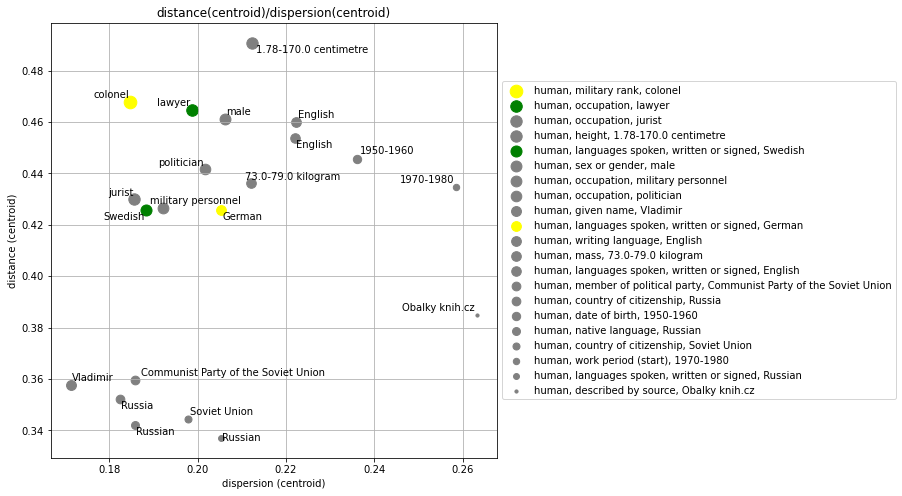

In [481]:
plot_surprise_metrics(entity_profile_labels_df, "dispersion (centroid)", "distance (centroid)", "plab_label", "distance(centroid)/dispersion(centroid)", "surprise_label")

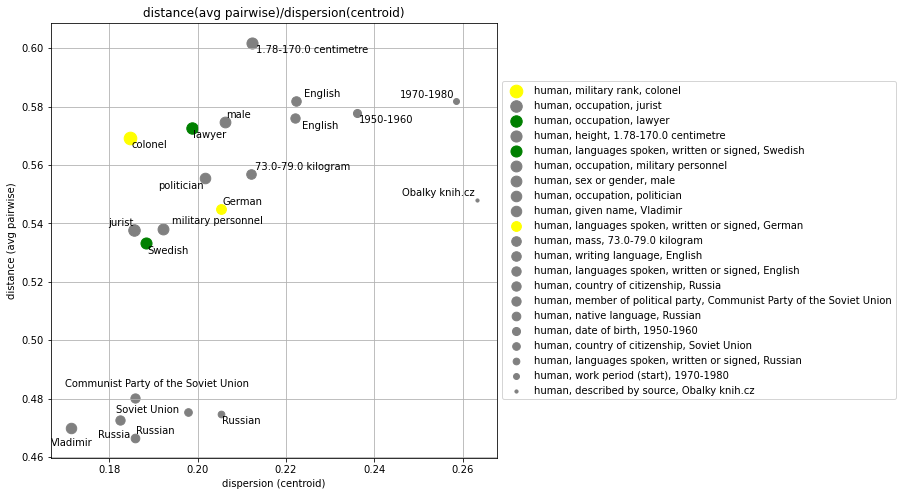

In [483]:
plot_surprise_metrics(entity_profile_labels_df, "dispersion (centroid)", "distance (avg pairwise)", "plab_label", "distance(avg pairwise)/dispersion(centroid)", "surprise_label")


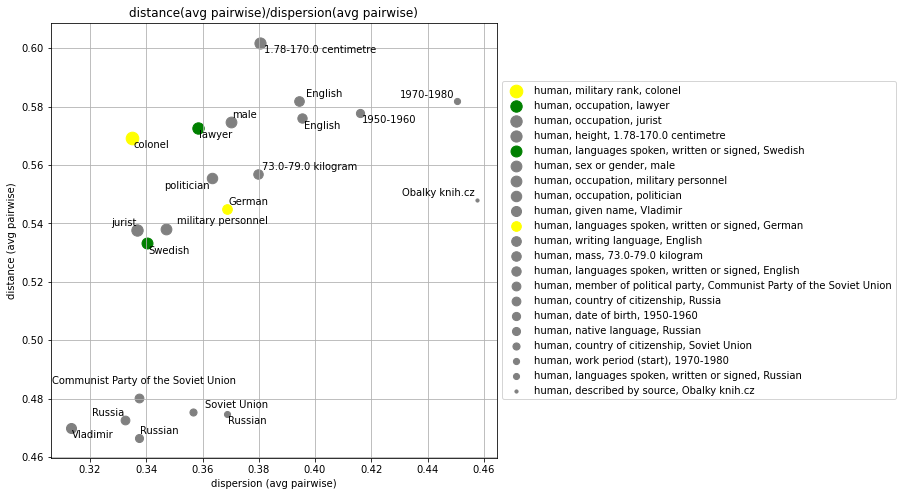

In [484]:
plot_surprise_metrics(entity_profile_labels_df, "dispersion (avg pairwise)", "distance (avg pairwise)", "plab_label", "distance(avg pairwise)/dispersion(avg pairwise)", "surprise_label")


### Looking at entity vs sample for specific profile labels

In [351]:
ent = "Q7747"
ent_embed = get_embed(ent)
# label_id = "Q5_P410_Q104680"  # military rank colonel 
# label_id = "Q5_P106_Q40348"  # lawyer
# label_id = "Q5_P2048_1.78-170.0__Q174728"  # height
label_id = "Q5_P1412_Q9027"  # languages = sweden
ents_sharing_label = get_entities_with_profile_label(label_id, ent, limit=10000)
sample_embeds = get_embeds(ents_sharing_label)
centroid = np.mean(sample_embeds, axis=0)

# Set up a logs directory, so Tensorboard knows where to look for files.
log_dir=f'{output_dir}/logs/putin_languages=sweden/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for sample_ent in ents_sharing_label:
        f.write(f"{sample_ent} ({labels_en_dict[sample_ent]})\n")
    f.write(f"sample centroid\n")
    f.write(f"{ent} ({labels_en_dict[ent]})\n")

# Save the weights we want to analyze as a variable.
weights = tf.Variable(np.vstack([sample_embeds,centroid,ent_embed]))
# Create a checkpoint from embedding, the filename and key are the
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

Putin -- military rank

In [336]:
%tensorboard --logdir {log_dir} --port 6008

Reusing TensorBoard on port 6008 (pid 63156), started 0:00:08 ago. (Use '!kill 63156' to kill it.)

Putin -- Lawyer

In [339]:
%tensorboard --logdir {log_dir} --port 6009

Reusing TensorBoard on port 6009 (pid 64864), started 0:00:37 ago. (Use '!kill 64864' to kill it.)

Putin -- height

In [342]:
%tensorboard --logdir {log_dir} --port 6010

Reusing TensorBoard on port 6010 (pid 468), started 0:00:16 ago. (Use '!kill 468' to kill it.)

languages = swedish

In [354]:
%tensorboard --logdir {log_dir} --port 6012

Reusing TensorBoard on port 6012 (pid 1828), started 0:00:32 ago. (Use '!kill 1828' to kill it.)

### Obama (Q76)

In [490]:
ent = "Q76"

Retrieve profile-labels

In [491]:
%%time
entity_profile_labels_df = get_entity_profile_labels_df(profile_labels_df, ent)

CPU times: user 52 ms, sys: 2.92 s, total: 2.97 s
Wall time: 18.6 s


Annotate ground truth surprise using my judgment...

In [492]:
with pd.option_context("max_colwidth",None):
    display(list(entity_profile_labels_df.loc[:,"plab_label"]))

['human, sex or gender, male',
 'human, occupation, politician',
 'human, country of citizenship, United States of America',
 'human, languages spoken, written or signed, English',
 'human, occupation, lawyer',
 'human, described by source, Obalky knih.cz',
 'human, member of political party, Democratic Party',
 'human, ethnic group, African Americans',
 'human, writing language, English',
 'human, work location, Washington, D.C.',
 'human, educated at, Columbia University',
 'human, member of, American Academy of Arts and Sciences',
 'human, mass, 79.0-88.0 kilogram',
 'human, date of birth, 1960-1970']

In [493]:
entity_profile_labels_df.loc[:,"surprise_label"]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0]

/nas/home/nmklein/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Compute surprise metrics and add them to the table

In [494]:
entity_profile_labels_df = compute_surprise_metrics_for_df(ent, entity_profile_labels_df, embedding_models["complex"], sample=10000, pairwise_sample=10000)


100%|███████████████████████████████████████████████████████████████████████████████████| 14/14 [04:06<00:00, 17.62s/it]


In [495]:
with pd.option_context("max_colwidth",None):
    display(entity_profile_labels_df.sort_values("distance(avg pairwise)/dispersion(avg pairwise)", ascending=False).loc[:,["id","plab_label", "distance (centroid)", "distance (avg pairwise)", "dispersion (centroid)", "dispersion (avg pairwise)", "distance(centroid)/dispersion(centroid)", "distance(avg pairwise)/dispersion(centroid)", "distance(avg pairwise)/dispersion(avg pairwise)"]])
    

id  \
368450                 Q5_P937_Q61   
368281              Q5_P102_Q29552   
368140             Q5_P21_Q6581097   
533410  Q5_P2067_79.0-88.0__Q11570   
368143              Q5_P106_Q82955   
368181              Q5_P106_Q40348   
368485               Q5_P69_Q49088   
368336              Q5_P172_Q49085   
605957           Q5_P569_1960-1970   
368151              Q5_P1412_Q1860   
368407              Q5_P6886_Q1860   
368144                  Q5_P27_Q30   
368576             Q5_P463_Q463303   
368211          Q5_P1343_Q67311526   

                                                     plab_label  \
368450                   human, work location, Washington, D.C.   
368281       human, member of political party, Democratic Party   
368140                               human, sex or gender, male   
533410                          human, mass, 79.0-88.0 kilogram   
368143                            human, occupation, politician   
368181                                human, occupation, lawyer   
368485                  human, educated at, Columbia University   
368336                   human, ethnic group, African Americans   
605957                          human, date of birth, 1960-1970   
368151      human, languages spoken, written or signed, English   
368407                         human, writing language, English   
368144  human, country of citizenship, United States of America   
368576  human, member of, American Academy of Arts and Sciences   
368211               human, described by source, Obalky knih.cz   

        distance (centroid)  distance (avg pairwise)  dispersion (centroid)  \
368450             0.385942                 0.476230               0.144592   
368281             0.382784                 0.485778               0.164025   
368140             0.473812                 0.585335               0.206256   
533410             0.479312                 0.592276               0.215461   
368143             0.431153                 0.547774               0.201629   
368181             0.405230                 0.525566               0.198653   
368485             0.425149                 0.550256               0.211810   
368336             0.396199                 0.522054               0.205421   
605957             0.445351                 0.578853               0.237409   
368151             0.411768                 0.544577               0.221996   
368407             0.406181                 0.540688               0.222324   
368144             0.377908                 0.514020               0.216547   
368576             0.364703                 0.511454               0.229789   
368211             0.364515                 0.533148               0.263180   

        dispersion (avg pairwise)  distance(centroid)/dispersion(centroid)  \
368450                   0.267699                                 2.669184   
368281                   0.302008                                 2.333696   
368140                   0.370119                                 2.297199   
533410                   0.385188                                 2.224586   
368143                   0.363569                                 2.138346   
368181                   0.359676                                 2.039885   
368485                   0.378557                                 2.007221   
368336                   0.367462                                 1.928714   
605957                   0.418100                                 1.875887   
368151                   0.395245                                 1.854841   
368407                   0.394379                                 1.826972   
368144                   0.387906                                 1.745152   
368576                   0.407093                                 1.587122   
368211                   0.456793                                 1.385042   

        distance(avg pairwise)/dispersion(centroid)  \
368450                                     

Consider metrics when sample is based on type only (e.g. compare Putin to random humans)

In [496]:
compute_surprise_metrics_sampling_by_type(ent, "Q5", embedding_models["complex"], sample=10000, pairwise_sample=10000)

{'dispersion (centroid)': 0.2692204642742872,
 'distance (centroid)': 0.4462987184524536,
 'distance(centroid)/dispersion(centroid)': 1.6577444053352333,
 'distance (avg pairwise)': 0.5979864424951374,
 'distance(avg pairwise)/dispersion(centroid)': 2.2211775174932353,
 'dispersion (avg pairwise)': 0.46650081284679473,
 'distance(avg pairwise)/dispersion(avg pairwise)': 1.2818550922686696}

Plotting

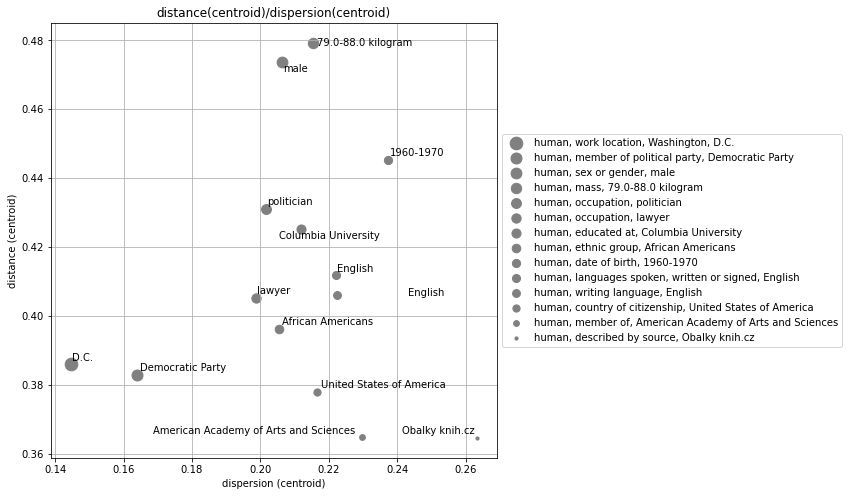

In [497]:
plot_surprise_metrics(entity_profile_labels_df, "dispersion (centroid)", "distance (centroid)", "plab_label", "distance(centroid)/dispersion(centroid)", "surprise_label")

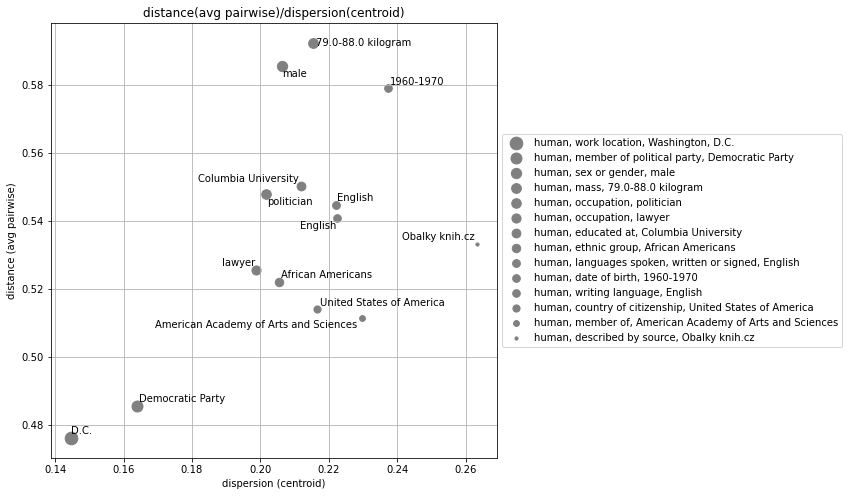

In [498]:
plot_surprise_metrics(entity_profile_labels_df, "dispersion (centroid)", "distance (avg pairwise)", "plab_label", "distance(avg pairwise)/dispersion(centroid)", "surprise_label")


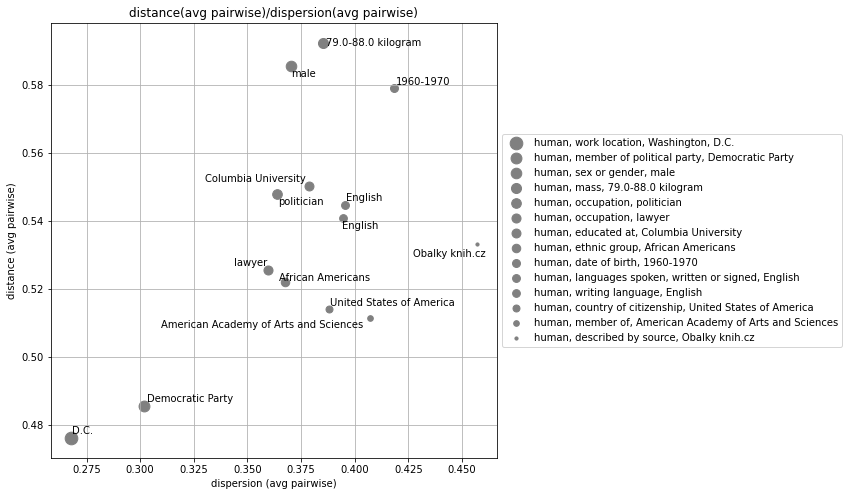

In [499]:
plot_surprise_metrics(entity_profile_labels_df, "dispersion (avg pairwise)", "distance (avg pairwise)", "plab_label", "distance(avg pairwise)/dispersion(avg pairwise)", "surprise_label")


### John Oliver (Q1701254)

In [500]:
ent = "Q1701254"

Retrieve profile-labels

In [501]:
%%time
entity_profile_labels_df = get_entity_profile_labels_df(profile_labels_df, ent)

CPU times: user 61.3 ms, sys: 3.07 s, total: 3.13 s
Wall time: 18.7 s


Annotate ground truth surprise using my judgment...

In [502]:
with pd.option_context("max_colwidth",None):
    display(list(entity_profile_labels_df.loc[:,"plab_label"]))

['human, sex or gender, male',
 'human, country of citizenship, United States of America',
 'human, occupation, actor',
 'human, occupation, writer',
 'human, languages spoken, written or signed, English',
 'human, country of citizenship, United Kingdom',
 'human, given name, John',
 'human, occupation, journalist',
 'human, given name, William',
 'human, occupation, film actor',
 'human, occupation, screenwriter',
 'human, occupation, television actor',
 'human, occupation, television presenter',
 'human, occupation, television producer',
 'human, number of children, 0.0-2.0',
 'human, date of birth, 1970-1980',
 'human, work period (start), 1990-2000']

In [503]:
entity_profile_labels_df.loc[:,"surprise_label"]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

/nas/home/nmklein/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Compute surprise metrics and add them to the table

In [504]:
entity_profile_labels_df = compute_surprise_metrics_for_df(ent, entity_profile_labels_df, embedding_models["complex"], sample=10000, pairwise_sample=10000)


100%|███████████████████████████████████████████████████████████████████████████████████| 17/17 [04:16<00:00, 15.07s/it]


In [505]:
with pd.option_context("max_colwidth",None):
    display(entity_profile_labels_df.sort_values("distance(avg pairwise)/dispersion(avg pairwise)", ascending=False).loc[:,["id","plab_label", "distance (centroid)", "distance (avg pairwise)", "dispersion (centroid)", "dispersion (avg pairwise)", "distance(centroid)/dispersion(centroid)", "distance(avg pairwise)/dispersion(centroid)", "distance(avg pairwise)/dispersion(avg pairwise)"]])
    

id  \
368162    Q5_P735_Q4925477   
368177   Q5_P735_Q12344159   
368140     Q5_P21_Q6581097   
368147      Q5_P106_Q33999   
368148      Q5_P106_Q36180   
368163    Q5_P106_Q1930187   
368153         Q5_P27_Q145   
368356     Q5_P106_Q947873   
605958   Q5_P569_1970-1980   
368144          Q5_P27_Q30   
368200      Q5_P106_Q28389   
368188   Q5_P106_Q10800557   
368224   Q5_P106_Q10798782   
368483     Q5_P106_Q578109   
368151      Q5_P1412_Q1860   
605994  Q5_P2031_1990-2000   
533413  Q5_P1971_0.0-2.0__   

                                                     plab_label  \
368162                                  human, given name, John   
368177                               human, given name, William   
368140                               human, sex or gender, male   
368147                                 human, occupation, actor   
368148                                human, occupation, writer   
368163                            human, occupation, journalist   
368153            human, country of citizenship, United Kingdom   
368356                  human, occupation, television presenter   
605958                          human, date of birth, 1970-1980   
368144  human, country of citizenship, United States of America   
368200                          human, occupation, screenwriter   
368188                            human, occupation, film actor   
368224                      human, occupation, television actor   
368483                   human, occupation, television producer   
368151      human, languages spoken, written or signed, English   
605994                    human, work period (start), 1990-2000   
533413                       human, number of children, 0.0-2.0   

        distance (centroid)  distance (avg pairwise)  dispersion (centroid)  \
368162             0.324063                 0.446816               0.176286   
368177             0.310130                 0.432589               0.173102   
368140             0.341832                 0.480638               0.206256   
368147             0.319263                 0.465719               0.210838   
368148             0.317688                 0.470332               0.220012   
368163             0.310771                 0.461121               0.215146   
368153             0.289807                 0.440599               0.208924   
368356             0.302103                 0.458184               0.220117   
605958             0.328517                 0.489791               0.237723   
368144             0.295165                 0.449268               0.216547   
368200             0.280859                 0.441591               0.219773   
368188             0.295630                 0.461572               0.232790   
368224             0.276069                 0.440794               0.224649   
368483             0.263356                 0.424530               0.214323   
368151             0.273715                 0.437306               0.221996   
605994             0.294851                 0.474948               0.252407   
533413             0.276187                 0.479895               0.279238   

        dispersion (avg pairwise)  distance(centroid)/dispersion(centroid)  \
368162                   0.321357                                 1.838285   
368177                   0.316403                                 1.791602   
368140                   0.369617                                 1.657316   
368147                   0.378010                                 1.514261   
368148                   0.390184                                 1.443957   
368163                   0.383420                                 1.444467   
368153                   0.373004                                 1.387144   
368356                   0.390802                                 1.372464   
605958                   0.417953                                 1.381931   
368144                   0.385525                                 1.36305

Consider metrics when sample is based on type only (e.g. compare Putin to random humans)

In [510]:
compute_surprise_metrics_sampling_by_type(ent, "Q5", embedding_models["complex"], sample=10000, pairwise_sample=10000)

{'dispersion (centroid)': 0.2692204642742872,
 'distance (centroid)': 0.32564425468444824,
 'distance(centroid)/dispersion(centroid)': 1.2095821005370355,
 'distance (avg pairwise)': 0.509786182912346,
 'distance(avg pairwise)/dispersion(centroid)': 1.8935640137406704,
 'dispersion (avg pairwise)': 0.46569137163162233,
 'distance(avg pairwise)/dispersion(avg pairwise)': 1.0946867688920896}

Plotting

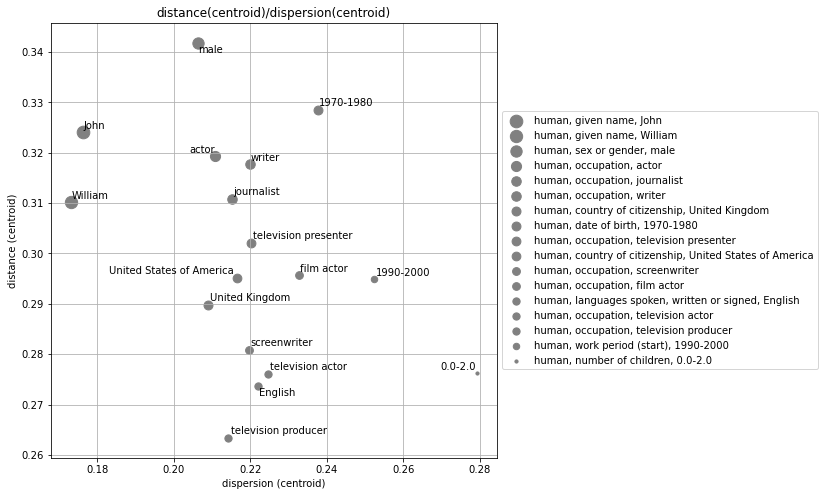

In [511]:
plot_surprise_metrics(entity_profile_labels_df, "dispersion (centroid)", "distance (centroid)", "plab_label", "distance(centroid)/dispersion(centroid)", "surprise_label")

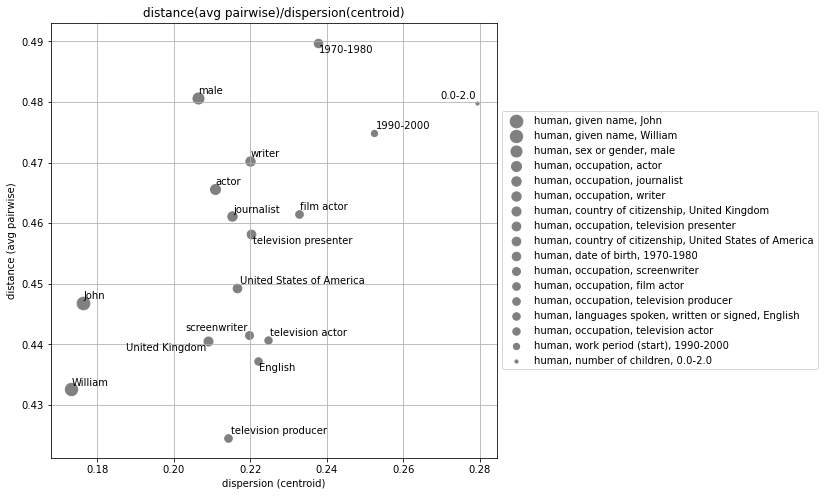

In [512]:
plot_surprise_metrics(entity_profile_labels_df, "dispersion (centroid)", "distance (avg pairwise)", "plab_label", "distance(avg pairwise)/dispersion(centroid)", "surprise_label")


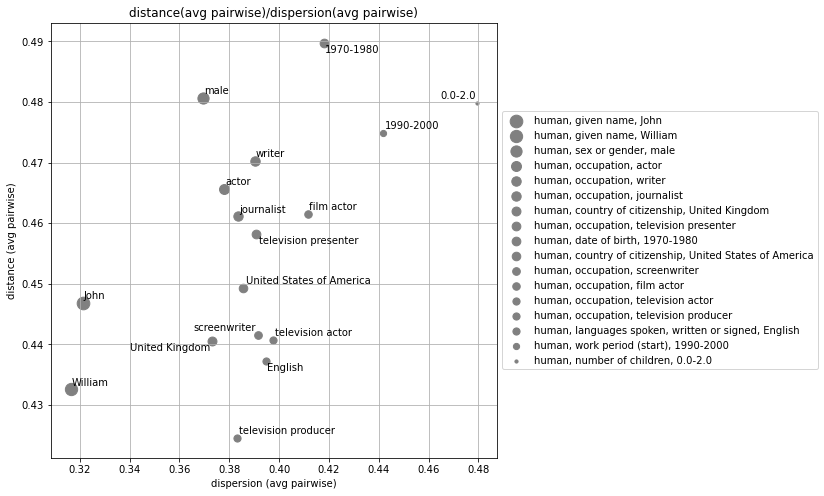

In [513]:
plot_surprise_metrics(entity_profile_labels_df, "dispersion (avg pairwise)", "distance (avg pairwise)", "plab_label", "distance(avg pairwise)/dispersion(avg pairwise)", "surprise_label")


### Roger Federer (Q1426)

In [514]:
ent = "Q1426"

Retrieve profile-labels

In [515]:
%%time
entity_profile_labels_df = get_entity_profile_labels_df(profile_labels_df, ent)

CPU times: user 61.5 ms, sys: 2.64 s, total: 2.7 s
Wall time: 18.3 s


Annotate ground truth surprise using my judgment...

In [516]:
with pd.option_context("max_colwidth",None):
    display(list(entity_profile_labels_df.loc[:,"plab_label"]))

['human, sex or gender, male',
 'human, languages spoken, written or signed, English',
 'human, languages spoken, written or signed, German',
 'human, languages spoken, written or signed, French',
 'human, religion, Catholic Church',
 'human, described by source, Obalky knih.cz',
 'human, country of citizenship, Switzerland',
 'human, country of citizenship, South Africa',
 'human, native language, German',
 'human, occupation, tennis player',
 'human, sport, tennis',
 'human, participant in, 2004 Summer Olympics',
 'human, participant in, 2000 Summer Olympics',
 'human, given name, Roger',
 'human, height, 183.0-188.0 centimetre',
 'human, mass, 79.0-88.0 kilogram',
 'human, date of birth, 1980-1990',
 'human, work period (start), 1990-2000']

In [517]:
entity_profile_labels_df.loc[:,"surprise_label"]=[0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0]

/nas/home/nmklein/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Compute surprise metrics and add them to the table

In [518]:
entity_profile_labels_df = compute_surprise_metrics_for_df(ent, entity_profile_labels_df, embedding_models["complex"], sample=10000, pairwise_sample=10000)


100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [05:28<00:00, 18.27s/it]


In [519]:
with pd.option_context("max_colwidth",None):
    display(entity_profile_labels_df.sort_values("distance(avg pairwise)/dispersion(avg pairwise)", ascending=False).loc[:,["id","plab_label", "distance (centroid)", "distance (avg pairwise)", "dispersion (centroid)", "dispersion (avg pairwise)", "distance(centroid)/dispersion(centroid)", "distance(avg pairwise)/dispersion(centroid)", "distance(avg pairwise)/dispersion(avg pairwise)"]])
    

id  \
368461                   Q5_P103_Q188   
368176                  Q5_P140_Q9592   
368582               Q5_P735_Q4925304   
368140                Q5_P21_Q6581097   
368495                   Q5_P641_Q847   
368492              Q5_P106_Q10833314   
368405                    Q5_P27_Q258   
368154                  Q5_P1412_Q188   
368165                  Q5_P1412_Q150   
368577                 Q5_P1344_Q8544   
533410     Q5_P2067_79.0-88.0__Q11570   
368543                 Q5_P1344_Q8558   
368225                     Q5_P27_Q39   
533407  Q5_P2048_183.0-188.0__Q174728   
605960              Q5_P569_1980-1990   
368151                 Q5_P1412_Q1860   
605994             Q5_P2031_1990-2000   
368211             Q5_P1343_Q67311526   

                                                 plab_label  \
368461                       human, native language, German   
368176                     human, religion, Catholic Church   
368582                             human, given name, Roger   
368140                           human, sex or gender, male   
368495                                 human, sport, tennis   
368492                     human, occupation, tennis player   
368405          human, country of citizenship, South Africa   
368154   human, languages spoken, written or signed, German   
368165   human, languages spoken, written or signed, French   
368577          human, participant in, 2000 Summer Olympics   
533410                      human, mass, 79.0-88.0 kilogram   
368543          human, participant in, 2004 Summer Olympics   
368225           human, country of citizenship, Switzerland   
533407                human, height, 183.0-188.0 centimetre   
605960                      human, date of birth, 1980-1990   
368151  human, languages spoken, written or signed, English   
605994                human, work period (start), 1990-2000   
368211           human, described by source, Obalky knih.cz   

        distance (centroid)  distance (avg pairwise)  dispersion (centroid)  \
368461             0.369123                 0.477337               0.168121   
368176             0.361267                 0.476244               0.176530   
368582             0.348824                 0.469420               0.182182   
368140             0.372912                 0.505308               0.206256   
368495             0.298215                 0.417467               0.167371   
368492             0.297913                 0.417824               0.168352   
368405             0.313600                 0.439939               0.182551   
368154             0.353203                 0.487243               0.205193   
368165             0.337298                 0.477332               0.209278   
368577             0.322758                 0.460945               0.202607   
533410             0.337613                 0.482009               0.215447   
368543             0.317763                 0.457423               0.203954   
368225             0.300895                 0.438355               0.194636   
533407             0.338170                 0.485514               0.220374   
605960             0.356763                 0.508234               0.234119   
368151             0.332969                 0.481955               0.221996   
605994             0.348408                 0.514527               0.252407   
368211             0.310940                 0.493248               0.263180   

        dispersion (avg pairwise)  distance(centroid)/dispersion(centroid)  \
368461                   0.308893                                 2.195583   
368176                   0.322233                                 2.046492   
368582                   0.332104                                 1.914700   
368140                   0.369994                                 1.808003   
368495                   0.307582                                 1.781756   
368492                   0.308410                                 1.769584   
368405   

Consider metrics when sample is based on type only (e.g. compare Putin to random humans)

In [520]:
compute_surprise_metrics_sampling_by_type(ent, "Q5", embedding_models["complex"], sample=10000, pairwise_sample=10000)

{'dispersion (centroid)': 0.2692204642742872,
 'distance (centroid)': 0.35160863399505615,
 'distance(centroid)/dispersion(centroid)': 1.306024915092748,
 'distance (avg pairwise)': 0.5286074681654572,
 'distance(avg pairwise)/dispersion(centroid)': 1.963474320536426,
 'dispersion (avg pairwise)': 0.46523496693745253,
 'distance(avg pairwise)/dispersion(avg pairwise)': 1.1362161181589017}

Plotting

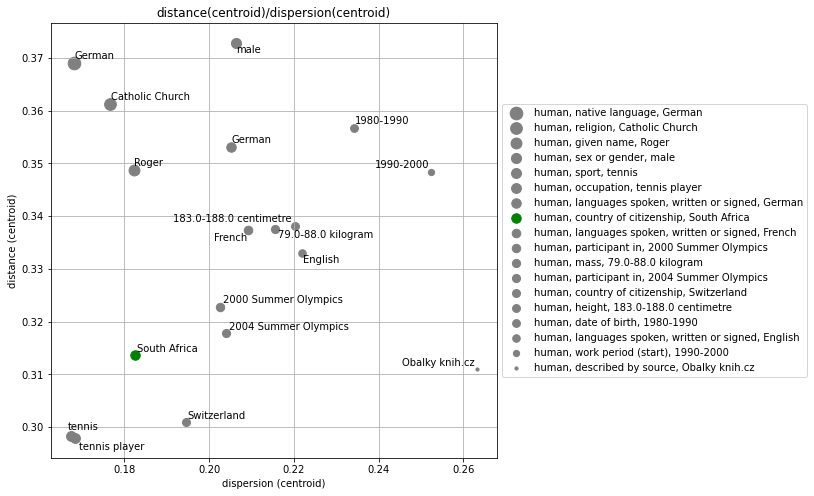

In [521]:
plot_surprise_metrics(entity_profile_labels_df, "dispersion (centroid)", "distance (centroid)", "plab_label", "distance(centroid)/dispersion(centroid)", "surprise_label")

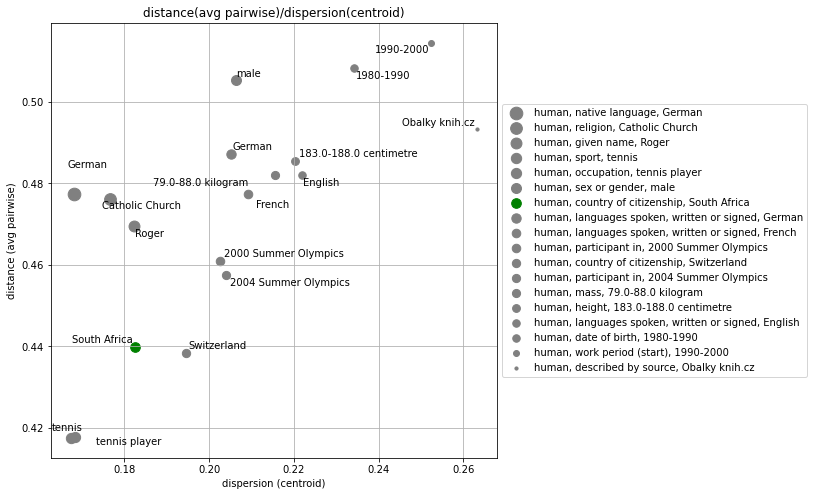

In [522]:
plot_surprise_metrics(entity_profile_labels_df, "dispersion (centroid)", "distance (avg pairwise)", "plab_label", "distance(avg pairwise)/dispersion(centroid)", "surprise_label")


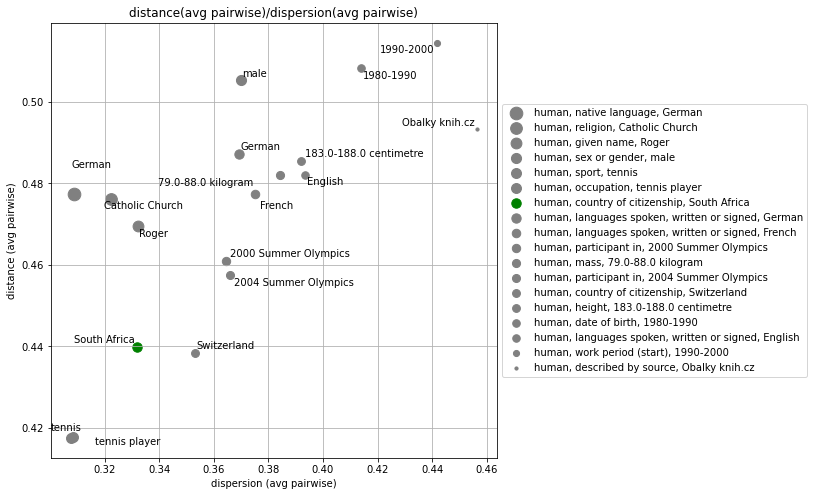

In [523]:
plot_surprise_metrics(entity_profile_labels_df, "dispersion (avg pairwise)", "distance (avg pairwise)", "plab_label", "distance(avg pairwise)/dispersion(avg pairwise)", "surprise_label")


### Apple, Inc. (Q312)

In [524]:
ent = "Q312"

Retrieve profile-labels

In [525]:
%%time
entity_profile_labels_df = get_entity_profile_labels_df(profile_labels_df, ent)

CPU times: user 67.1 ms, sys: 2.93 s, total: 3 s
Wall time: 18 s


Apple has multiple instance of values. Let's just use business...

In [535]:
entity_profile_labels_df = entity_profile_labels_df.loc[["business," in label for label in entity_profile_labels_df.loc[:,"plab_label"]]]

Annotate ground truth surprise using my judgment...

In [536]:
with pd.option_context("max_colwidth",None):
    display(list(entity_profile_labels_df.loc[:,"plab_label"]))

['business, instance of, enterprise',
 'business, country, United States of America',
 'business, stock exchange, NASDAQ',
 'business, product or material produced, software',
 'business, industry, mobile phone industry',
 'business, instance of, brand',
 'business, industry, software industry',
 'business, part of, S&P 500',
 'business, industry, consumer electronics',
 'business, industry, information technology',
 'business, industry, electronics',
 'business, stock exchange, Tokyo Stock Exchange',
 'business, member of, Wi-Fi Alliance',
 'business, member of, SD Association',
 'business, country of origin, United States of America',
 'business, instance of, trademark',
 'business, product or material produced, computer hardware',
 'business, employees, 12533.0-9125654456456.0',
 'business, inception, 1970-1980']

In [538]:
entity_profile_labels_df.loc[:,"surprise_label"]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

/nas/home/nmklein/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Compute surprise metrics and add them to the table

In [540]:
entity_profile_labels_df = compute_surprise_metrics_for_df(ent, entity_profile_labels_df, embedding_models["complex"], sample=10000, pairwise_sample=10000)


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [07:03<00:00, 22.31s/it]


In [541]:
with pd.option_context("max_colwidth",None):
    display(entity_profile_labels_df.sort_values("distance(avg pairwise)/dispersion(avg pairwise)", ascending=False).loc[:,["id","plab_label", "distance (centroid)", "distance (avg pairwise)", "dispersion (centroid)", "dispersion (avg pairwise)", "distance(centroid)/dispersion(centroid)", "distance(avg pairwise)/dispersion(centroid)", "distance(avg pairwise)/dispersion(avg pairwise)"]])
    

id  \
360507                          Q4830453_P17_Q30   
360534                      Q4830453_P1056_Q7397   
360506                     Q4830453_P31_Q6881511   
604972                   Q4830453_P571_1970-1980   
360583                   Q4830453_P452_Q56598901   
360602                     Q4830453_P452_Q581105   
360717                      Q4830453_P31_Q167270   
360532                      Q4830453_P414_Q82059   
360589                      Q4830453_P31_Q431289   
360713                         Q4830453_P495_Q30   
360649                     Q4830453_P414_Q217475   
360629                      Q4830453_P452_Q11661   
360641                      Q4830453_P452_Q11650   
360678                    Q4830453_P463_Q7389502   
360599                     Q4830453_P452_Q880371   
360600                     Q4830453_P361_Q242345   
360759                      Q4830453_P1056_Q3966   
360655                    Q4830453_P463_Q1361045   
532830  Q4830453_P1128_12533.0-9125654456456.0__   

                                                       plab_label  \
360507                business, country, United States of America   
360534           business, product or material produced, software   
360506                          business, instance of, enterprise   
604972                             business, inception, 1970-1980   
360583                  business, industry, mobile phone industry   
360602                   business, industry, consumer electronics   
360717                           business, instance of, trademark   
360532                           business, stock exchange, NASDAQ   
360589                               business, instance of, brand   
360713      business, country of origin, United States of America   
360649             business, stock exchange, Tokyo Stock Exchange   
360629                 business, industry, information technology   
360641                            business, industry, electronics   
360678                        business, member of, SD Association   
360599                      business, industry, software industry   
360600                                 business, part of, S&P 500   
360759  business, product or material produced, computer hardware   
360655                        business, member of, Wi-Fi Alliance   
532830               business, employees, 12533.0-9125654456456.0   

        distance (centroid)  distance (avg pairwise)  dispersion (centroid)  \
360507             0.523329                 0.588888               0.125122   
360534             0.419325                 0.496574               0.111801   
360506             0.556738                 0.631335               0.154773   
604972             0.528471                 0.618470               0.182391   
360583             0.533471                 0.623799               0.186504   
360602             0.464376                 0.556612               0.164280   
360717             0.554307                 0.645596               0.193859   
360532             0.447468                 0.546079               0.169647   
360589             0.493035                 0.589760               0.184380   
360713             0.489030                 0.596832               0.192657   
360649             0.463297                 0.572903               0.185032   
360629             0.436302                 0.549474               0.183686   
360641             0.458332                 0.570413               0.191500   
360678             0.414924                 0.532586               0.182708   
360599             0.396071                 0.510854               0.178805   
360600             0.434567                 0.553052               0.199765   
360759             0.364046                 0.487770               0.179822   
360655             0.368827                 0.508369               0.206012   
532830             0.441157                 0.594566               0.264229   

        dispersion (avg pairwise)  distance

Consider metrics when sample is based on type only (e.g. compare Putin to random humans)

In [546]:
compute_surprise_metrics_sampling_by_type(ent, "Q4830453", embedding_models["complex"], sample=10000, pairwise_sample=10000)

{'dispersion (centroid)': 0.19289614325463772,
 'distance (centroid)': 0.5289148390293121,
 'distance(centroid)/dispersion(centroid)': 2.7419668952691496,
 'distance (avg pairwise)': 0.6245833109587431,
 'distance(avg pairwise)/dispersion(centroid)': 3.2379253437651427,
 'dispersion (avg pairwise)': 0.3477419918000698,
 'distance(avg pairwise)/dispersion(avg pairwise)': 1.7961112712491736}

Plotting

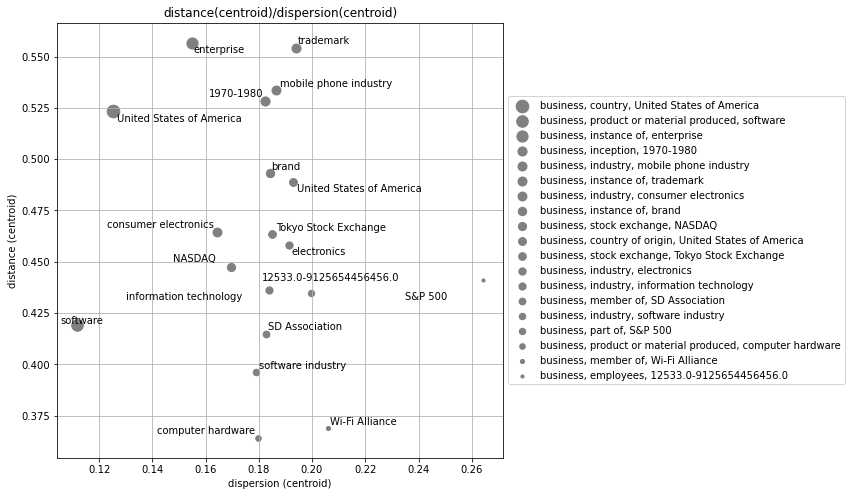

In [547]:
plot_surprise_metrics(entity_profile_labels_df, "dispersion (centroid)", "distance (centroid)", "plab_label", "distance(centroid)/dispersion(centroid)", "surprise_label")

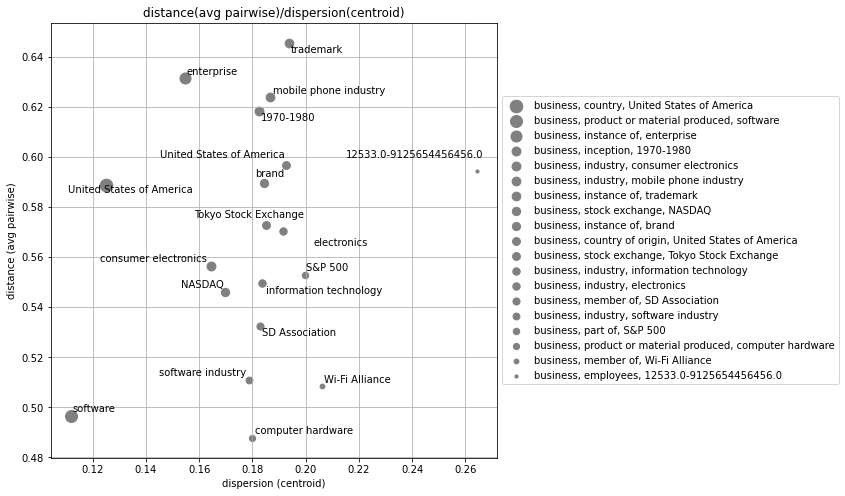

In [548]:
plot_surprise_metrics(entity_profile_labels_df, "dispersion (centroid)", "distance (avg pairwise)", "plab_label", "distance(avg pairwise)/dispersion(centroid)", "surprise_label")


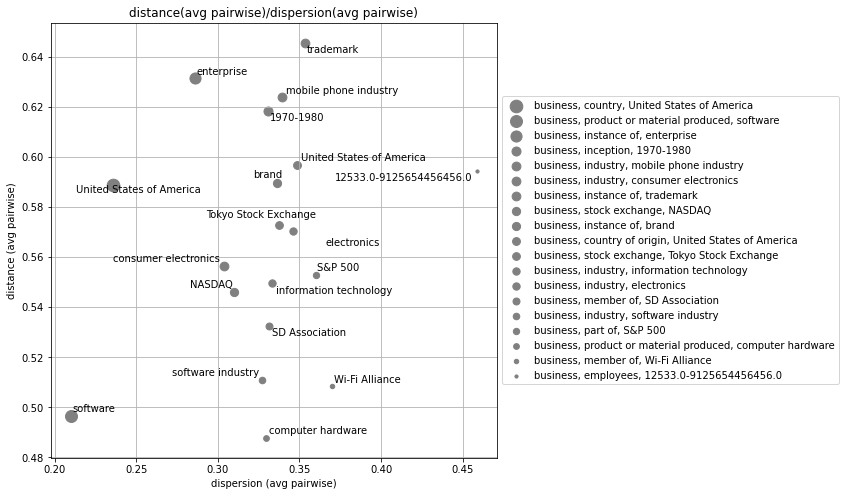

In [549]:
plot_surprise_metrics(entity_profile_labels_df, "dispersion (avg pairwise)", "distance (avg pairwise)", "plab_label", "distance(avg pairwise)/dispersion(avg pairwise)", "surprise_label")


In [574]:
fun_facts_df = pd.read_csv("/data02/profiling/FunFacts/experiment_results/evaluation_study/Batch_2482873_batch_results.csv")

In [577]:
with pd.option_context("max_columns",None):
    display(fun_facts_df)

HITId                       HITTypeId  \
0     3D4BBDG7ZHWUK9GGXGOB5ZPQLCJC30  395K4VYE01OS8Y32V15IJCOSE3W65A   
1     3D4BBDG7ZHWUK9GGXGOB5ZPQLCJC30  395K4VYE01OS8Y32V15IJCOSE3W65A   
2     3D4BBDG7ZHWUK9GGXGOB5ZPQLCJC30  395K4VYE01OS8Y32V15IJCOSE3W65A   
3     3D4BBDG7ZHWUK9GGXGOB5ZPQLCJC30  395K4VYE01OS8Y32V15IJCOSE3W65A   
4     3D4BBDG7ZHWUK9GGXGOB5ZPQLCJC30  395K4VYE01OS8Y32V15IJCOSE3W65A   
...                              ...                             ...   
2175  3XBYQ44Z6P48XOKFTMU3Z60R7RDWT9  395K4VYE01OS8Y32V15IJCOSE3W65A   
2176  3XBYQ44Z6P48XOKFTMU3Z60R7RDWT9  395K4VYE01OS8Y32V15IJCOSE3W65A   
2177  3XBYQ44Z6P48XOKFTMU3Z60R7RDWT9  395K4VYE01OS8Y32V15IJCOSE3W65A   
2178  3XBYQ44Z6P48XOKFTMU3Z60R7RDWT9  395K4VYE01OS8Y32V15IJCOSE3W65A   
2179  3XBYQ44Z6P48XOKFTMU3Z60R7RDWT9  395K4VYE01OS8Y32V15IJCOSE3W65A   

             Title                                  Description  \
0     Trivia Game!  Which fact would be good for a trivia game?   
1     Trivia Game!  Which fact would be good for a trivia game?   
2     Trivia Game!  Which fact would be good for a trivia game?   
3     Trivia Game!  Which fact would be good for a trivia game?   
4     Trivia Game!  Which fact would be good for a trivia game?   
...            ...                                          ...   
2175  Trivia Game!  Which fact would be good for a trivia game?   
2176  Trivia Game!  Which fact would be good for a trivia game?   
2177  Trivia Game!  Which fact would be good for a trivia game?   
2178  Trivia Game!  Which fact would be good for a trivia game?   
2179  Trivia Game!  Which fact would be good for a trivia game?   

               Keywords Reward                  CreationTime  MaxAssignments  \
0     trivia, questions  $0.04  Mon Aug 01 08:03:24 PDT 2016               5   
1     trivia, questions  $0.04  Mon Aug 01 08:03:24 PDT 2016               5   
2     trivia, questions  $0.04  Mon Aug 01 08:03:24 PDT 2016               5   
3     trivia, questions  $0.04  Mon Aug 01 08:03:24 PDT 2016               5   
4     trivia, questions  $0.04  Mon Aug 01 08:03:24 PDT 2016               5   
...                 ...    ...                           ...             ...   
2175  trivia, questions  $0.04  Mon Aug 01 08:03:40 PDT 2016               5   
2176  trivia, questions  $0.04  Mon Aug 01 08:03:40 PDT 2016               5   
2177  trivia, questions  $0.04  Mon Aug 01 08:03:40 PDT 2016               5   
2178  trivia, questions  $0.04  Mon Aug 01 08:03:40 PDT 2016               5   
2179  trivia, questions  $0.04  Mon Aug 01 08:03:40 PDT 2016               5   

     RequesterAnnotation  AssignmentDurationInSeconds  \
0       BatchId:2482873;                         3600   
1       BatchId:2482873;                         3600   
2       BatchId:2482873;                         3600   
3       BatchId:2482873;                         3600   
4       BatchId:2482873;                         3600   
...                  ...                          ...   
2175    BatchId:2482873;                         3600   
2176    BatchId:2482873;                         3600   
2177    BatchId:2482873;                         3600   
2178    BatchId:2482873;                         3600   
2179    BatchId:2482873;                         3600   

      AutoApprovalDelayInSeconds                    Expiration  \
0                          86400  Thu Aug 04 08:03:24 PDT 2016   
1                          86400  Thu Aug 04 08:03:24 PDT 2016   
2                          86400  Thu Aug 04 08:03:24 PDT 2016   
3                          86400  Thu Aug 04 08:03:24 PDT 2016   
4                          86400  Thu Aug 04 08:03:24 PDT 2016   
...                          ...                           ...   
2175                       86400  Thu Aug 04 08:03:40 PDT 2016   
2176                       86400  Thu Aug 04 08:03:40 PDT 2016   
2177                       86400  Thu Aug 04 08:03:40 PDT 2016   
2178                       86400  Thu Aug 04 08:03:40 P

In [591]:
with pd.option_context("max_colwidth",None,"max_rows",None):
    display(fun_facts_df.loc[:,["Input.Article","Input.Fact","Input.Score","Input.Type","Answer.comment","Answer.goodTrivia","Answer.knew","Answer.surprising","Approve","Reject"]])
    

Input.Article  \
0               George Soros   
1               George Soros   
2               George Soros   
3               George Soros   
4               George Soros   
5               George Soros   
6               George Soros   
7               George Soros   
8               George Soros   
9               George Soros   
10              George Soros   
11              George Soros   
12              George Soros   
13              George Soros   
14              George Soros   
15              George Soros   
16              George Soros   
17              George Soros   
18              George Soros   
19              George Soros   
20            George W. Bush   
21            George W. Bush   
22            George W. Bush   
23            George W. Bush   
24            George W. Bush   
25            George W. Bush   
26            George W. Bush   
27            George W. Bush   
28            George W. Bush   
29            George W. Bush   
30            George W. Bush   
31            George W. Bush   
32            George W. Bush   
33            George W. Bush   
34            George W. Bush   
35            George W. Bush   
36            George W. Bush   
37            George W. Bush   
38            George W. Bush   
39            George W. Bush   
40         George Washington   
41         George Washington   
42         George Washington   
43         George Washington   
44         George Washington   
45         George Washington   
46         George Washington   
47         George Washington   
48         George Washington   
49         George Washington   
50         George Washington   
51         George Washington   
52         George Washington   
53         George Washington   
54         George Washington   
55         George Washington   
56         George Washington   
57         George Washington   
58         George Washington   
59         George Washington   
60          Gonzalo HiguaÃ­n   
61          Gonzalo HiguaÃ­n   
62          Gonzalo HiguaÃ­n   
63          Gonzalo HiguaÃ­n   
64          Gonzalo HiguaÃ­n   
65          Gonzalo HiguaÃ­n   
66          Gonzalo HiguaÃ­n   
67          Gonzalo HiguaÃ­n   
68          Gonzalo HiguaÃ­n   
69          Gonzalo HiguaÃ­n   
70          Gonzalo HiguaÃ­n   
71          Gonzalo HiguaÃ­n   
72          Gonzalo HiguaÃ­n   
73          Gonzalo HiguaÃ­n   
74          Gonzalo HiguaÃ­n   
75      A. P. J. Abdul Kalam   
76      A. P. J. Abdul Kalam   
77      A. P. J. Abdul Kalam   
78      A. P. J. Abdul Kalam   
79      A. P. J. Abdul Kalam   
80          Gonzalo HiguaÃ­n   
81          Gonzalo HiguaÃ­n   
82          Gonzalo HiguaÃ­n   
83          Gonzalo HiguaÃ­n   
84          Gonzalo HiguaÃ­n   
85              Heath Ledger   
86              Heath Ledger   
87              Heath Ledger   
88              Heath Ledger   
89              Heath Ledger   
90              Heath Ledger   
91              Heath Ledger   
92              Heath Ledger   
93              Heath Ledger   
94              Heath Ledger   
95      A. P. J. Abdul Kalam   
96      A. P. J. Abdul Kalam   
97      A. P. J. Abdul Kalam   
98      A. P. J. Abdul Kalam   
99      A. P. J. Abdul Kalam   
100     A. P. J. Abdul Kalam   
101     A. P. J. Abdul Kalam   
102     A. P. J. Abdul Kalam   
103     A. P. J. Abdul Kalam   
104     A. P. J. Abdul Kalam   
105             Heath Ledger   
106             Heath Ledger   
107             Heath Ledger   
108             Heath Ledger   
109             Heath Ledger   
110     A. P. J. Abdul Kalam   
111     A. P. J. Abdul Kalam   
112     A. P. J. Abdul Kalam   
113     A. P. J. Abdul Kalam   
114     A. P. J. Abdul Kalam   
115             Heath Ledger   
116             Heath Ledger   
117             Heath Ledger   
118             Heath Ledger   
119             Heath Ledger   
120           Tom Hiddleston   
121           Tom Hiddleston   
122           Tom Hiddleston   
123           Tom Hiddleston   
124           T

In [594]:
fun_facts_agg_df = fun_facts_df.groupby(["Input.Article","Input.Fact","Input.Type"]).agg({"Answer.goodTrivia" : "mean","Answer.knew" : "mean","Answer.surprising" : "mean"})
with pd.option_context("max_colwidth",None,"max_rows",None):
    display(fun_facts_agg_df)

Answer.goodTrivia  \
Input.Article          Input.Fact                                                                                                                                                                                                                                                                                   Input.Type                      
A. P. J. Abdul Kalam   A. P. J. Abdul Kalam is in the group of Indian aerospace engineers                                                                                                                                                                                                                           ourMiddle                0.00   
                       A. P. J. Abdul Kalam is in the group of Nuclear energy in India                                                                                                                                                                                                                              ourTop                  -0.20   
                       A. P. J. Abdul Kalam is in the group of Recipients of the Padma Vibhushan                                                                                                                                                                                                                    ourBottom               -0.60   
                       On 10 June 2002, the National Democratic Alliance (NDA) which was in power at the time, expressed that they would nominate Kalam for the post of President, and both the Samajwadi Party and the Nationalist Congress Party backed his candidacy.                                            baseline                -0.40   
Abraham Lincoln        Abraham Lincoln is in the group of People of Illinois in the American Civil War                                                                                                                                                                                                              ourMiddle               18.40   
                       Abraham Lincoln is in the group of Presidents of the United States                                                                                                                                                                                                                           ourBottom               -1.80   
                       Abraham Lincoln is in the group of Smallpox survivors                                                                                                                                                                                                                                        ourTop                   1.60   
                       There was also the Great Moments with Mr. Lincoln exhibit in Disneyland, and the Hall of Presidents at Walt Disney World, which had to do with Walt Disney admiring Lincoln ever since he was a little boy.                                                                                  baseline                 1.40   
Akshay Kumar           Akshay Kumar is in the group of Akshay Kumar                                                                                                                                                                                                                                                 ourBottom               38.40   
                       Akshay Kumar is in the group of Canadian game show hosts                                                                                                                                                                                                                                     ourTop                  -0.60   
                       Akshay Kumar is in the group of Indian stunt performers                                                                                                                                                      

In [597]:
fun_facts_agg_df.iloc[:,-3:].describe()

Answer.goodTrivia  Answer.knew  Answer.surprising
count         436.000000   436.000000         436.000000
mean            8.567890    -0.608104           8.647248
std            23.314361     1.391316          23.582371
min            -2.000000    -2.000000          -2.000000
25%            -1.000000    -2.000000          -1.200000
50%            -0.400000    -1.200000          -0.400000
75%             1.000000     0.400000           0.800000
max            99.000000     2.000000          99.000000

In [598]:
mask = []
for i, row in fun_facts_agg_df.iterrows():
    in_range = True
    for col in ["Answer.goodTrivia","Answer.knew","Answer.surprising"]:
        val = row[col]
        if val < -2.0 or val > 2.0:
            in_range = False
            break
    mask.append(in_range)

In [599]:
fun_facts_agg_df.iloc[mask,-3:].describe()

Answer.goodTrivia  Answer.knew  Answer.surprising
count         362.000000   362.000000         362.000000
mean           -0.460773    -0.523757          -0.538674
std             0.938117     1.416225           0.919771
min            -2.000000    -2.000000          -2.000000
25%            -1.200000    -2.000000          -1.400000
50%            -0.600000    -1.200000          -0.800000
75%             0.200000     0.400000           0.200000
max             1.800000     2.000000           1.800000

In [606]:
with pd.option_context("max_colwidth",None,"max_rows",None):
    display(fun_facts_agg_df.loc[(fun_facts_agg_df.loc[:,"Answer.surprising"] >= 0.2) & mask])

Answer.goodTrivia  \
Input.Article          Input.Fact                                                                                                                                                                                                                                                                          Input.Type                      
A. P. J. Abdul Kalam   A. P. J. Abdul Kalam is in the group of Indian aerospace engineers                                                                                                                                                                                                                  ourMiddle                0.00   
Abraham Lincoln        Abraham Lincoln is in the group of Smallpox survivors                                                                                                                                                                                                                               ourTop                   1.60   
                       There was also the Great Moments with Mr. Lincoln exhibit in Disneyland, and the Hall of Presidents at Walt Disney World, which had to do with Walt Disney admiring Lincoln ever since he was a little boy.                                                                         baseline                 1.40   
Akshay Kumar           Joker was reportedly promoted as Kumar's 100th film, but later Akshay Kumar clarified that the 100th film landmark had been crossed long before he even signed up for Joker.                                                                                                        baseline                 0.20   
Alan Rickman           Alan Rickman is in the group of Alumni of Chelsea College of Art & Design                                                                                                                                                                                                           ourTop                   1.00   
                       In 1965, at the age of 19, Rickman met 18-year-old Rima Horton, who became his girlfriend and would later be a Labour Party councillor on the Kensington and Chelsea London Borough Council (1986–2006) and an economics lecturer at the nearby Kingston University.                baseline                 0.60   
Albert Einstein        Albert Einstein is in the group of American Zionists                                                                                                                                                                                                                                ourTop                   0.25   
                       Einstein offered and was called on to give judgments and opinions on matters often unrelated to theoretical physics or mathematics.                                                                                                                                                 baseline                -0.20   
Alec Baldwin           Baldwin said in a 2006 interview with The New York Times that if he did become involved in electoral politics, he would prefer to run for Governor of New York.                                                                                                                     baseline                 1.20   
Alicia Vikander        Alicia Vikander is in the group of Royal Swedish Ballet dancers                                                                                                                                                                                                                     ourTop                   0.20   
Amber Heard            Amber Heard is in the group of Objectivists                                                                                                                                                                                                                                         ourTop                   1.2

In [636]:
%%time
list(get_entity_profile_labels_df(profile_labels_df, "Q238663").loc[:,"plab_label"])

CPU times: user 43.7 ms, sys: 3.15 s, total: 3.19 s
Wall time: 18.5 s


['human, sex or gender, female',
 'human, country of citizenship, United States of America',
 'human, country for sport, United States of America',
 'human, participant in, 2012 Summer Olympics',
 'human, height, 1.78-170.0 centimetre',
 'human, mass, 1.0-66.0 kilogram',
 'human, date of birth, 1990-2000']

In [639]:
wd_mapped_ff_agg.to_csv("/data02/profiling/FunFacts/experiment_results/evaluation_study/funfacts_mapped_to_wd.tsv", sep='\t')

In [646]:
len(set(wd_mapped_ff_agg.reset_index()["Input.Article"]))

109

In [637]:
wd_mapped_ff_agg = fun_facts_agg_df.loc[mask]
in_wd_list = [1,0,1,0,
              1,0,0,
              0,0,0,
              1,1,1,0,
              1,0,1,0,
              1,0,1,0,
              0,0,
              1,0,0,1,
              1,2,0,0,
              
             ]
in_profiles_list = [1,0,0,0,
                    0,0,0,
                    0,0,0,
                    2,0,1,0,
                    0,0,0,0,
                    2,0,0,0,
                    0,0,
                    1,0,0,0,
                    0,0,0,0,
                    
                   ]
while len(in_wd_list) < len(wd_mapped_ff_agg):
    in_wd_list.append(np.nan)
while len(in_profiles_list) < len(wd_mapped_ff_agg):
    in_profiles_list.append(np.nan)
wd_mapped_ff_agg.loc[:,"in WD?"] = in_wd_list
wd_mapped_ff_agg.loc[:,"likely in profiles?"] = in_profiles_list

with pd.option_context("max_colwidth",None,"max_rows",None):
    display(wd_mapped_ff_agg.loc[:,['in WD?', 'likely in profiles?', 'Answer.goodTrivia', 'Answer.knew', 'Answer.surprising']])

/nas/home/nmklein/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


in WD?  \
Input.Article          Input.Fact                                                                                                                                                                                                                                                                                   Input.Type           
A. P. J. Abdul Kalam   A. P. J. Abdul Kalam is in the group of Indian aerospace engineers                                                                                                                                                                                                                           ourMiddle      1.0   
                       A. P. J. Abdul Kalam is in the group of Nuclear energy in India                                                                                                                                                                                                                              ourTop         0.0   
                       A. P. J. Abdul Kalam is in the group of Recipients of the Padma Vibhushan                                                                                                                                                                                                                    ourBottom      1.0   
                       On 10 June 2002, the National Democratic Alliance (NDA) which was in power at the time, expressed that they would nominate Kalam for the post of President, and both the Samajwadi Party and the Nationalist Congress Party backed his candidacy.                                            baseline       0.0   
Abraham Lincoln        Abraham Lincoln is in the group of Presidents of the United States                                                                                                                                                                                                                           ourBottom      1.0   
                       Abraham Lincoln is in the group of Smallpox survivors                                                                                                                                                                                                                                        ourTop         0.0   
                       There was also the Great Moments with Mr. Lincoln exhibit in Disneyland, and the Hall of Presidents at Walt Disney World, which had to do with Walt Disney admiring Lincoln ever since he was a little boy.                                                                                  baseline       0.0   
Akshay Kumar           Akshay Kumar is in the group of Canadian game show hosts                                                                                                                                                                                                                                     ourTop         0.0   
                       Akshay Kumar is in the group of Indian stunt performers                                                                                                                                                                                                                                      ourMiddle      0.0   
                       Joker was reportedly promoted as Kumar's 100th film, but later Akshay Kumar clarified that the 100th film landmark had been crossed long before he even signed up for Joker.                                                                                                                 baseline       0.0   
Alan Rickman           Alan Rickman is in the group of 20th-century English male actors                                                                                                                                                                                                                             ourMiddle      1.0   
                       Alan Ri

In [205]:
index.metric_type

1

In [10]:
%time kgtk_sim_index = faiss.read_index("/data02/profiling/kgtk_sim_complex_embeddings/wikidata-20210215-dwd-v2-similarity-embed.2021-10-03T12:14.complexemb.faiss.index.nlist=8192.train=10M.idx")

CPU times: user 1.31 s, sys: 24.1 s, total: 25.4 s
Wall time: 1min 39s


In [11]:
kgtk_sim_index.metric_type

1

In [212]:
del kgtk_sim_index

In [13]:
!ls /data02/profiling/kgtk_sim_complex_embeddings/

complexemb_numids.tsv
wikidata-20210215-dwd-v2-similarity-embed.2021-10-03T12:14.complexemb.faiss.index.nlist=8192.train=10M.idx
wikidata-20210215-dwd-v2-similarity-embed.2021-10-03T12:14.complex.np.mmap
wikidata-20210215-dwd-v2-similarity-main.2021-10-03T12:02.sqlite3.db


In [14]:
numids_df = pd.read_csv("/data02/profiling/kgtk_sim_complex_embeddings/complexemb_numids.tsv", sep='\t')

In [15]:
kgtk_sim_ent_to_index = {ent : idx for ent,idx in zip(numids_df.loc[:,"node1"], numids_df.loc[:,"node2"])}

In [16]:
kgtk_sim_ent_list = list(numids_df.loc[:,"node1"])

In [17]:
kgtk_sim_ent_to_index["Q41"]

47461554

In [18]:
fp = np.memmap("/data02/profiling/kgtk_sim_complex_embeddings/wikidata-20210215-dwd-v2-similarity-embed.2021-10-03T12:14.complex.np.mmap", dtype='float32', mode='r', shape=(len(kgtk_sim_ent_list),100))

In [19]:
len(fp)

53002670

In [20]:
fp

memmap([[-0.02400555, -0.8686192 ,  0.06295895, ...,  0.15405169,
         -0.14448248,  0.74363273],
        [-0.07362542, -0.84912133,  0.11165518, ...,  0.01388327,
          0.52053326,  0.6606953 ],
        [ 0.08602697, -0.8452038 , -0.01865273, ..., -0.30987978,
         -0.07268021,  0.32849914],
        ...,
        [ 0.0962668 , -0.6805172 ,  0.2791584 , ...,  0.06037776,
         -0.04137786,  0.5157679 ],
        [-0.05223182, -0.6510764 ,  0.17175046, ..., -0.01836912,
         -0.1619895 ,  0.28126293],
        [ 0.13910863, -0.7356009 ,  0.09923635, ..., -0.26410982,
         -0.00460193,  0.51049465]], dtype=float32)

In [98]:
faiss.downcast_index(kgtk_sim_index.quantizer).hnsw.efSearch = 128
kgtk_sim_index.nprobe = 64

In [101]:
dists, ent_idxs = kgtk_sim_index.search(kgtk_sim_index.reconstruct(kgtk_sim_ent_to_index["Q41"])[np.newaxis,:], 21)

In [102]:
for dist, ent_idx in zip(dists[0], ent_idxs[0]):
    qnode = kgtk_sim_ent_list[ent_idx]
    print("{}, {}, dist: {:.7f}, sim:{:.6f}".format(qnode, labels_en_dict[qnode], dist, cosine_similarity(fp[kgtk_sim_ent_to_index['Q41']][None,:], fp[kgtk_sim_ent_to_index[qnode]][None,:])[0,0]))

Q41, 'Greece'@en, dist: 0.0000000, sim:1.000000
Q414, 'Argentina'@en, dist: 6.7262330, sim:0.805612
Q35, 'Denmark'@en, dist: 7.1711416, sim:0.807039
Q37, 'Lithuania'@en, dist: 7.5422378, sim:0.770431
Q790, 'Haiti'@en, dist: 7.7651658, sim:0.761649
Q79, 'Egypt'@en, dist: 8.0842247, sim:0.752212
Q822, 'Lebanon'@en, dist: 8.1775312, sim:0.752542
Q114, 'Kenya'@en, dist: 8.2518806, sim:0.745667
Q419, 'Peru'@en, dist: 8.3975801, sim:0.743041
Q244, 'Barbados'@en, dist: 8.9949570, sim:0.725452
Q224, 'Croatia'@en, dist: 9.1049385, sim:0.712930
Q928, 'Philippines'@en, dist: 9.1561365, sim:0.737291
Q43, 'Turkey'@en, dist: 9.2941761, sim:0.702841
Q774, 'Guatemala'@en, dist: 9.4507675, sim:0.710505
Q228, 'Andorra'@en, dist: 9.5837994, sim:0.700442
Q28513, 'Austria-Hungary'@en, dist: 9.6168404, sim:0.724732
Q766, 'Jamaica'@en, dist: 9.6352949, sim:0.716508
Q953, 'Zambia'@en, dist: 9.7643471, sim:0.687582
Q233, 'Malta'@en, dist: 9.8284473, sim:0.728673
Q865, 'Taiwan'@en, dist: 10.1695518, sim:0.68038

Checking for Argentina...

In [651]:
cosine_similarity(fp[kgtk_sim_ent_to_index['Q41']][None,:], fp[kgtk_sim_ent_to_index["Q414"]][None,:])

array([[0.80561185]], dtype=float32)

In [32]:
kgtk_sim_ent_to_index["Q414"]

9731054

In [71]:
dists, ent_idxs = kgtk_sim_index.search(kgtk_sim_index.reconstruct(kgtk_sim_ent_to_index["Q414"])[np.newaxis,:], 11)

In [72]:
for dist, ent_idx in zip(dists[0], ent_idxs[0]):
    qnode = kgtk_sim_ent_list[ent_idx]
    print("{}, {}, dist: {:.7f}, sim:{:.6f}".format(qnode, labels_en_dict[qnode], dist, cosine_similarity(fp[kgtk_sim_ent_to_index['Q41']][None,:], fp[kgtk_sim_ent_to_index[qnode]][None,:])[0,0]))

Q414, 'Argentina'@en, dist: 0.0000000, sim:0.805612
Q298, 'Chile'@en, dist: 7.2844982, sim:0.673915
Q790, 'Haiti'@en, dist: 8.1496258, sim:0.761649
Q774, 'Guatemala'@en, dist: 8.6810875, sim:0.710505
Q1008, 'Ivory Coast'@en, dist: 8.9089127, sim:0.577745
Q800, 'Costa Rica'@en, dist: 9.2927694, sim:0.687246
Q77, 'Uruguay'@en, dist: 9.3014727, sim:0.629389
Q1000, 'Gabon'@en, dist: 9.4802313, sim:0.643027
Q96, 'Mexico'@en, dist: 9.6650085, sim:0.650127
Q750, 'Bolivia'@en, dist: 9.7007160, sim:0.595604
Q155, 'Brazil'@en, dist: 9.9623508, sim:0.628305


In [85]:
_, greece_ent_idxs = kgtk_sim_index.search(kgtk_sim_index.reconstruct(kgtk_sim_ent_to_index["Q41"])[np.newaxis,:], 1000)

In [86]:
len(set(greece_ent_idxs[0]))

887

In [87]:
_, argentina_ent_idxs = kgtk_sim_index.search(kgtk_sim_index.reconstruct(kgtk_sim_ent_to_index["Q414"])[np.newaxis,:], 100000)

In [88]:
len(set(argentina_ent_idxs[0]))

10327

In [89]:
greece_ent_idxs = set(greece_ent_idxs[0]) - {-1}
argentina_ent_idxs = set(argentina_ent_idxs[0]) - {-1}
len(greece_ent_idxs & argentina_ent_idxs)

0

In [50]:
ent_idxs[0][887]

-1

In [63]:
np.linalg.norm(fp[kgtk_sim_ent_to_index['Q35']] - fp[kgtk_sim_ent_to_index["Q41"]], ord=2)

2.6778986

writing kgtk-sim-complex-embeddings to standard embedding file for use by faiss

In [ ]:
for ent, idx in tqdm(kgtk_sim_ent_to_index.items()):
#     _ = fp[idx]
    _ = kgtk_sim_index.reconstruct(idx)

In [113]:
with open("/data02/profiling/kgtk_sim_complex_embeddings/kgtk_sim_complex_embeddings.tsv", 'w+') as f:
    f.write("node1\tlabel\tnode2\n")  # header
    for ent, idx in tqdm(kgtk_sim_ent_to_index.items()):
        embed = kgtk_sim_index.reconstruct(idx)
        embed_str = ",".join(str(val) for val in embed)
        f.write("{}\tcomplex_embedding\t{}\n".format(ent, embed_str))

100%|██████████████████████████████████████████████████████████████████████| 53002670/53002670 [1:01:57<00:00, 14257.88it/s]


In [274]:
%time nic_kgtk_sim_index = faiss.read_index("/data02/profiling/kgtk_sim_complex_embeddings/nic_faiss/kgtk_sim_complex_embeddings.faiss.index.IVF8192_HNSW32,Flat.train=10M.metric=L2.idx")

CPU times: user 1.42 s, sys: 15.5 s, total: 16.9 s
Wall time: 16.9 s


In [275]:
nic_kgtk_sim_index.metric_type

1

In [339]:
nic_numids_df = pd.read_csv("/data02/profiling/kgtk_sim_complex_embeddings/nic_faiss/kgtk_sim_complex_embeddings.faiss.id_to_node.tsv", sep='\t')

In [340]:
nic_kgtk_sim_ent_to_index = {ent : idx for idx,ent in zip(nic_numids_df.loc[:,"node1"], nic_numids_df.loc[:,"node2"])}

In [285]:
nic_kgtk_sim_ent_list = list(nic_numids_df.loc[:,"node2"])

In [341]:
nic_kgtk_sim_ent_to_index["Q41"]

47461554

In [280]:
faiss.downcast_index(nic_kgtk_sim_index.quantizer).hnsw.efSearch = 128
nic_kgtk_sim_index.nprobe = 64

In [304]:
dists, ent_idxs = nic_kgtk_sim_index.search(nic_kgtk_sim_index.reconstruct(nic_kgtk_sim_ent_to_index["Q41"])[np.newaxis,:], 21)

In [305]:
for dist, ent_idx in zip(dists[0], ent_idxs[0]):
    qnode = nic_kgtk_sim_ent_list[ent_idx]
    print("{}, {}, dist: {:.7f}, sim:{:.6f}".format(qnode, labels_en_dict[qnode], dist, cosine_similarity(nic_kgtk_sim_index.reconstruct(nic_kgtk_sim_ent_to_index["Q41"])[None,:], nic_kgtk_sim_index.reconstruct(nic_kgtk_sim_ent_to_index[qnode])[None,:])[0,0]))

Q41, 'Greece'@en, dist: 0.0000000, sim:1.000000
Q414, 'Argentina'@en, dist: 6.7262330, sim:0.805612
Q35, 'Denmark'@en, dist: 7.1711416, sim:0.807039
Q37, 'Lithuania'@en, dist: 7.5422378, sim:0.770431
Q790, 'Haiti'@en, dist: 7.7651658, sim:0.761649
Q79, 'Egypt'@en, dist: 8.0842247, sim:0.752212
Q822, 'Lebanon'@en, dist: 8.1775312, sim:0.752542
Q419, 'Peru'@en, dist: 8.3975801, sim:0.743041
Q224, 'Croatia'@en, dist: 9.1049385, sim:0.712930
Q928, 'Philippines'@en, dist: 9.1561365, sim:0.737291
Q43, 'Turkey'@en, dist: 9.2941761, sim:0.702841
Q774, 'Guatemala'@en, dist: 9.4507675, sim:0.710505
Q228, 'Andorra'@en, dist: 9.5837994, sim:0.700442
Q28513, 'Austria-Hungary'@en, dist: 9.6168404, sim:0.724732
Q766, 'Jamaica'@en, dist: 9.6352949, sim:0.716508
Q953, 'Zambia'@en, dist: 9.7643471, sim:0.687582
Q865, 'Taiwan'@en, dist: 10.1695518, sim:0.680383
Q45, 'Portugal'@en, dist: 10.2420931, sim:0.680364
Q229, 'Cyprus'@en, dist: 10.3220367, sim:0.728404
Q794, 'Iran'@en, dist: 10.3424883, sim:0.705

In [489]:
!ls /data02/profiling/kgtk_sim_complex_embeddings

wikidata-20210215-dwd-v2-similarity-embed.2021-10-03T12:14.complexemb.faiss.index.nlist=8192.train=10M.idx
wikidata-20210215-dwd-v2-similarity-embed.2021-10-03T12:14.complex.np.mmap
wikidata-20210215-dwd-v2-similarity-main.2021-10-03T12:02.sqlite3.db.gz


In [ ]:
%%time
!kgtk query --gc wikidata-20210215-dwd-v2-similarity-main.2021-10-03T12:02.sqlite3.db -i complexemb_numids -o complexemb_numids.tsv

## PCA text embeddings

In [ ]:
pca_text_index_file = "/data02/profiling/dwd-v3.text-embeddings.PCA100/faiss_index/kgtk_text_embeddings.PCA100.faiss.index.IVF8192_HNSW32,Flat.train=10M.metric=L2.idx"
pca_text_index_id_to_node_file = "/data02/profiling/dwd-v3.text-embeddings.PCA100/faiss_index/kgtk_text_embeddings.PCA100.faiss.id_to_node.tsv"
pca_text_emb_file = "/data02/profiling/dwd-v3.text-embeddings.PCA100/faiss_index/kgtk_text_embeddings_all.PCA100.tsv"

In [115]:
%time text_emb_index = faiss.read_index(pca_text_index_file)

CPU times: user 1.65 s, sys: 20 s, total: 21.7 s
Wall time: 21.7 s


In [116]:
text_emb_index.metric_type

1

In [117]:
numids_df = pd.read_csv(pca_text_index_id_to_node_file, sep='\t')

In [118]:
text_emb_ent_to_index = {ent : idx for idx,ent in zip(numids_df.loc[:,"node1"], numids_df.loc[:,"node2"])}

In [119]:
text_emb_ent_list = list(numids_df.loc[:,"node2"])

In [120]:
text_emb_ent_to_index["Q41"]

6373942

In [ ]:
faiss.downcast_index(text_emb_index.quantizer).hnsw.efSearch = 128
text_emb_index.nprobe = 64

In [127]:
text_emb_index.set_direct_map_type(faiss.DirectMap.Array)

Loading all embs to a dict

In [122]:
text_emb_df = pd.read_csv(pca_text_emb_file, sep='\t')

In [ ]:
text_emb_dict = {}
for _, row in tqdm(text_emb_df.iterrows()):
    ent = row["node1"]
    embed = np.float32(row["node2"].split(','))
    text_emb_dict[ent] = embed

8961053it [13:43, 9812.46it/s] 

In [139]:
text_emb_index.reconstruct(text_emb_ent_to_index["Q41"])

array([-0.06800622,  4.2084904 , -4.0938745 , -7.0411334 , -1.725308  ,
        0.2695834 , -1.7008833 ,  5.9761477 ,  0.01768379,  3.5306537 ,
        0.33266506, -1.9394573 ,  1.4335611 , -0.19067326,  0.5802344 ,
        1.4580123 ,  4.354415  , -1.5383816 ,  0.961603  ,  2.4154484 ,
       -6.656278  , -2.1636145 , -2.2696223 , -2.6844459 ,  1.2324421 ,
       -0.39962122, -0.90445775,  0.3437167 ,  0.47569492, -4.082224  ,
       -1.424309  , -0.9315167 , -0.15045537, -0.8995702 , -1.1164176 ,
       -1.6155401 ,  0.19336744,  1.2378016 ,  1.6948824 ,  2.8119419 ,
        1.9872026 ,  1.5567286 ,  0.14649361,  2.016006  , -0.46706852,
       -1.1284231 , -0.81136084, -0.07862469, -3.9070497 , -0.6064548 ,
        2.1584854 ,  0.14579996, -1.1328632 ,  2.71016   ,  0.65110105,
       -2.4035575 ,  0.05398722, -0.4763723 , -1.5455714 ,  2.9480474 ,
        0.9230635 ,  0.06700105,  0.78841656, -0.3785176 ,  0.72176844,
       -0.35492823, -1.792348  , -1.995555  ,  0.2011833 , -0.93

In [140]:
dists, ent_idxs = text_emb_index.search(text_emb_index.reconstruct(text_emb_ent_to_index["Q41"])[np.newaxis,:], 11)

In [141]:
for dist, ent_idx in zip(dists[0], ent_idxs[0]):
    qnode = text_emb_ent_list[ent_idx]
    print("{}, {}, dist: {:.7f}, sim:{:.6f}".format(qnode, labels_en_dict[qnode] if qnode in labels_en_dict else "", dist, cosine_similarity(text_emb_dict['Q41'][None,:], text_emb_dict[qnode][None,:])[0,0]))

Q41, 'Greece'@en, dist: 0.0000000, sim:1.000000
Q25094385, , dist: 70.2079468, sim:0.908068
Q98544647, 'Kioupri, Edessa'@en, dist: 72.6608887, sim:0.901114
Q421226, 'Akrotiri, Crete'@en, dist: 75.2919159, sim:0.898186
Q56147553, '<Greek and Roman temple substructure components>'@en, dist: 84.5239182, sim:0.891704
Q12876192, 'Diapori'@en, dist: 86.7730560, sim:0.879518
Q16331199, 'Budali Hodja Tekke'@en, dist: 86.9729996, sim:0.885933
Q874192, 'Chios Prefecture'@en, dist: 87.6654205, sim:0.882032
Q25094202, , dist: 88.0745392, sim:0.889259
Q211314, 'Florina Prefecture'@en, dist: 88.3453903, sim:0.877728
Q106123127, , dist: 88.3886261, sim:0.877158


Loading orig embed subset

## Text embeddings

In [2]:
embedding_models["pca100_text"] = text_emb_dict

NameError: name 'text_emb_dict' is not defined

may be good idea to set up ent dfs in a dict so can do it just once.

In [153]:
ent_to_profile_labels_df = {}

### Putin (Q7747)

In [154]:
ent = "Q7747"

Retrieve profile-labels

In [161]:
%%time
ent_to_profile_labels_df[ent] = get_entity_profile_labels_df(profile_labels_df, ent)

CPU times: user 72.8 ms, sys: 5.77 s, total: 5.84 s
Wall time: 1min 16s


In [162]:
with pd.option_context("max_colwidth",None):
    display(list(ent_to_profile_labels_df[ent].loc[:,"plab_label"]))

['human, sex or gender, male',
 'human, occupation, politician',
 'human, languages spoken, written or signed, English',
 'human, languages spoken, written or signed, German',
 'human, occupation, lawyer',
 'human, country of citizenship, Soviet Union',
 'human, occupation, military personnel',
 'human, country of citizenship, Russia',
 'human, described by source, Obalky knih.cz',
 'human, languages spoken, written or signed, Russian',
 'human, occupation, jurist',
 'human, languages spoken, written or signed, Swedish',
 'human, writing language, English',
 'human, member of political party, Communist Party of the Soviet Union',
 'human, native language, Russian',
 'human, military rank, colonel',
 'human, given name, Vladimir',
 'human, height, 1.78-170.0 centimetre',
 'human, mass, 73.0-79.0 kilogram',
 'human, date of birth, 1950-1960',
 'human, work period (start), 1970-1980']

In [163]:
ent_to_profile_labels_df[ent].loc[:,"surprise_label"]=[0,0,0,1,2,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0]

/nas/home/nmklein/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Compute surprise metrics and add them to the table

In [181]:
ent_to_profile_labels_df[ent] = compute_surprise_metrics_for_df(ent, ent_to_profile_labels_df[ent], embedding_models["text"], "text", sample=10000, pairwise_sample=10000)


100%|███████████████████████████████████████████████████████████████████████████████████████| 21/21 [11:12<00:00, 32.03s/it]


In [ ]:
with pd.option_context("max_colwidth",None):
    display(ent_to_profile_labels_df[ent].sort_values("distance(avg pairwise)/dispersion(avg pairwise)", ascending=False).loc[:,["id","plab_label", "distance (centroid)", "distance (avg pairwise)", "dispersion (centroid)", "dispersion (avg pairwise)", "distance(centroid)/dispersion(centroid)", "distance(avg pairwise)/dispersion(centroid)", "distance(avg pairwise)/dispersion(avg pairwise)"]])
    

Consider metrics when sample is based on type only (e.g. compare Putin to random humans)

In [183]:
compute_surprise_metrics_sampling_by_type("Q7747", "Q5", embedding_models["text"], sample=10000, pairwise_sample=10000)

{'dispersion (centroid)': 0.5382804471581298,
 'distance (centroid)': 0.8433276414871216,
 'distance(centroid)/dispersion(centroid)': 1.5667068085781286,
 'distance (avg pairwise)': 0.9269919717629568,
 'distance(avg pairwise)/dispersion(centroid)': 1.7221356946124327,
 'dispersion (avg pairwise)': 0.788168245576565,
 'distance(avg pairwise)/dispersion(avg pairwise)': 1.1761346349152124}

Plotting

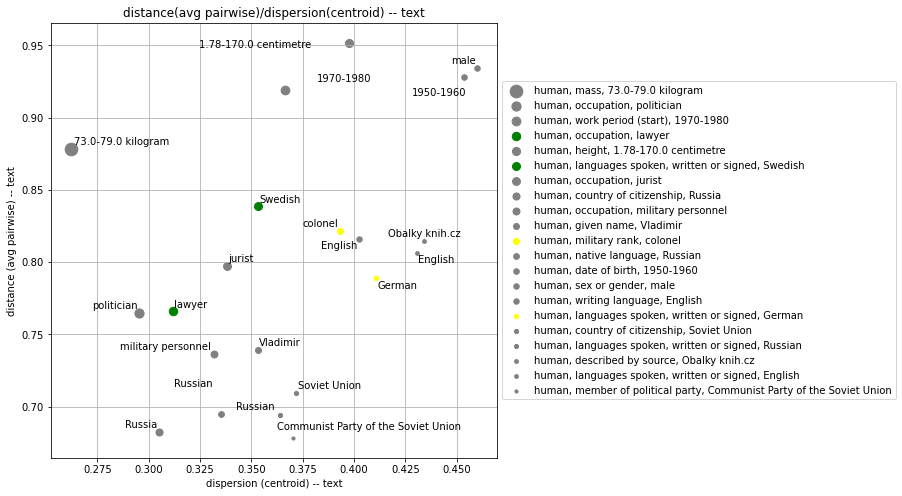

In [314]:
plot_surprise_metrics(ent_to_profile_labels_df[ent], "dispersion (centroid) -- text", "distance (avg pairwise) -- text", "plab_label", "distance(avg pairwise)/dispersion(centroid) -- text", "surprise_label")


**Why is mass so compact???**  
Let's look at some of the entities who have this...

In [318]:
mass_sample = list(get_entities_with_profile_label("Q5_P2067_73.0-79.0__Q11570", limit=1000, label_to_ents_dict=human_label_to_ents_dict))
mass_sample_embeds = [embedding_models["text"][ent] for ent in mass_sample]
mass_sample_centroid = np.mean(mass_sample_embeds, axis=0)
dists = [distance.cosine(mass_sample_centroid, e) for e in mass_sample_embeds]

### Looking at entity vs sample for specific profile labels

In [333]:
ent = "Q7747"
ent_embed = embedding_models["text"][ent]
# label_id = "Q5_P410_Q104680"  # military rank colonel 
# label_id = "Q5_P106_Q40348"  # lawyer
# label_id = "Q5_P2048_1.78-170.0__Q174728"  # height
label_id = "Q5_P2067_73.0-79.0__Q11570" # mass
# label_id = "Q5_P1412_Q9027"  # languages = sweden
ents_sharing_label = get_entities_with_profile_label(label_id, ent, 10000, human_label_to_ents_dict)
sample_embeds = np.array([embedding_models["text"][e] for e in ents_sharing_label if e in embedding_models["text"]])
centroid = np.mean(sample_embeds, axis=0)

# Set up a logs directory, so Tensorboard knows where to look for files.
log_dir=f'{output_dir}/logs/putin_mass/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for sample_ent in ents_sharing_label:
        if sample_ent not in embedding_models["text"]:
            continue
        f.write(f"{sample_ent} ({labels_en_dict[sample_ent]})\n")
    f.write(f"sample centroid\n")
    f.write(f"{ent} ({labels_en_dict[ent]})\n")

# Save the weights we want to analyze as a variable.
weights = tf.Variable(np.vstack([sample_embeds,centroid,ent_embed]))
# Create a checkpoint from embedding, the filename and key are the
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [338]:
weights.shape

TensorShape([9959, 100])

Putin -- military rank

In [288]:
%tensorboard --logdir {log_dir} --port 6008

Reusing TensorBoard on port 6008 (pid 36417), started 1:27:49 ago. (Use '!kill 36417' to kill it.)

Putin -- Mass

In [337]:
%tensorboard --logdir {log_dir} --port 6009

Reusing TensorBoard on port 6009 (pid 48849), started 0:14:57 ago. (Use '!kill 48849' to kill it.)

Putin -- height

In [292]:
%tensorboard --logdir {log_dir} --port 6010

Reusing TensorBoard on port 6010 (pid 36008), started 1:35:25 ago. (Use '!kill 36008' to kill it.)

languages = swedish

In [261]:
%tensorboard --logdir {log_dir} --port 6012

Reusing TensorBoard on port 6012 (pid 35326), started 0:03:49 ago. (Use '!kill 35326' to kill it.)

### Obama (Q76)

In [196]:
ent = "Q76"

Retrieve profile-labels

In [197]:
%%time
ent_to_profile_labels_df[ent] = get_entity_profile_labels_df(profile_labels_df, ent)

CPU times: user 44.4 ms, sys: 5.75 s, total: 5.79 s
Wall time: 35.9 s


Annotate ground truth surprise using my judgment...

In [198]:
with pd.option_context("max_colwidth",None):
    display(list(ent_to_profile_labels_df[ent].loc[:,"plab_label"]))

['human, sex or gender, male',
 'human, occupation, politician',
 'human, country of citizenship, United States of America',
 'human, languages spoken, written or signed, English',
 'human, occupation, lawyer',
 'human, described by source, Obalky knih.cz',
 'human, member of political party, Democratic Party',
 'human, ethnic group, African Americans',
 'human, writing language, English',
 'human, work location, Washington, D.C.',
 'human, educated at, Columbia University',
 'human, member of, American Academy of Arts and Sciences',
 'human, mass, 79.0-88.0 kilogram',
 'human, date of birth, 1960-1970']

In [199]:
ent_to_profile_labels_df[ent].loc[:,"surprise_label"]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0]

/nas/home/nmklein/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Compute surprise metrics and add them to the table

In [200]:
ent_to_profile_labels_df[ent] = compute_surprise_metrics_for_df(ent, ent_to_profile_labels_df[ent], embedding_models["text"], "text", sample=10000, pairwise_sample=10000)


100%|███████████████████████████████████████████████████████████████████████████████████████| 14/14 [07:18<00:00, 31.32s/it]


In [ ]:
with pd.option_context("max_colwidth",None):
    display(ent_to_profile_labels_df[ent].sort_values("distance(avg pairwise)/dispersion(avg pairwise) -- text", ascending=False).loc[:,["id","plab_label", "distance (centroid)", "distance (avg pairwise)", "dispersion (centroid)", "dispersion (avg pairwise)", "distance(centroid)/dispersion(centroid)", "distance(avg pairwise)/dispersion(centroid)", "distance(avg pairwise)/dispersion(avg pairwise)"]])
    

Consider metrics when sample is based on type only (e.g. compare Putin to random humans)

In [201]:
compute_surprise_metrics_sampling_by_type(ent, "Q5", embedding_models["text"], sample=10000, pairwise_sample=10000)

{'dispersion (centroid)': 0.5382804471581298,
 'distance (centroid)': 0.6750327944755554,
 'distance(centroid)/dispersion(centroid)': 1.2540540865628955,
 'distance (avg pairwise)': 0.8531953952368458,
 'distance(avg pairwise)/dispersion(centroid)': 1.5850388022476394,
 'dispersion (avg pairwise)': 0.7880824127569598,
 'distance(avg pairwise)/dispersion(avg pairwise)': 1.0826220474228074}

Plotting

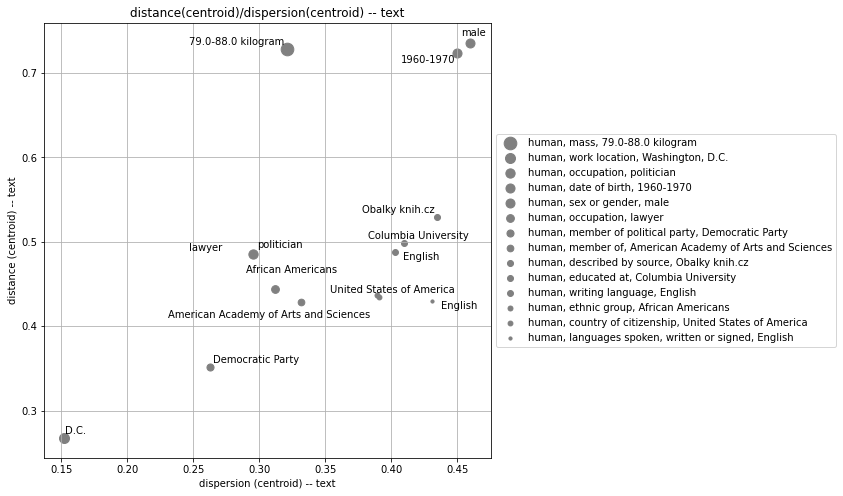

In [202]:
plot_surprise_metrics(ent_to_profile_labels_df[ent], "dispersion (centroid) -- text", "distance (centroid) -- text", "plab_label", "distance(centroid)/dispersion(centroid) -- text", "surprise_label")


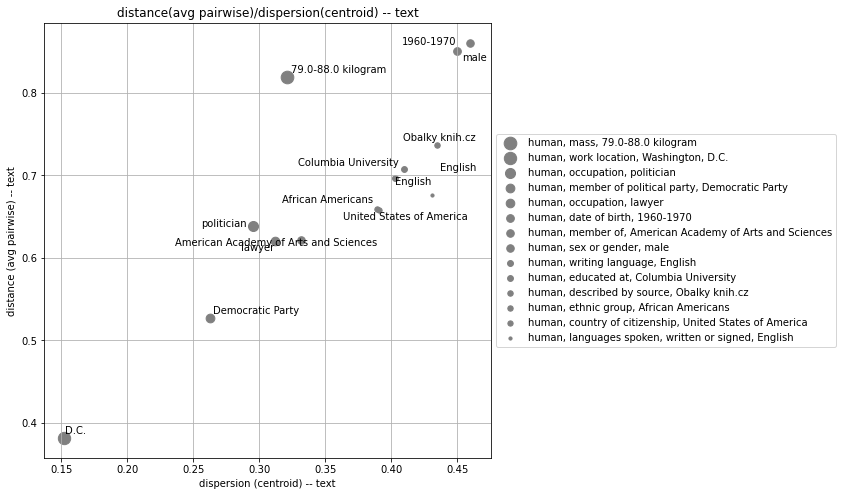

In [203]:
plot_surprise_metrics(ent_to_profile_labels_df[ent], "dispersion (centroid) -- text", "distance (avg pairwise) -- text", "plab_label", "distance(avg pairwise)/dispersion(centroid) -- text", "surprise_label")


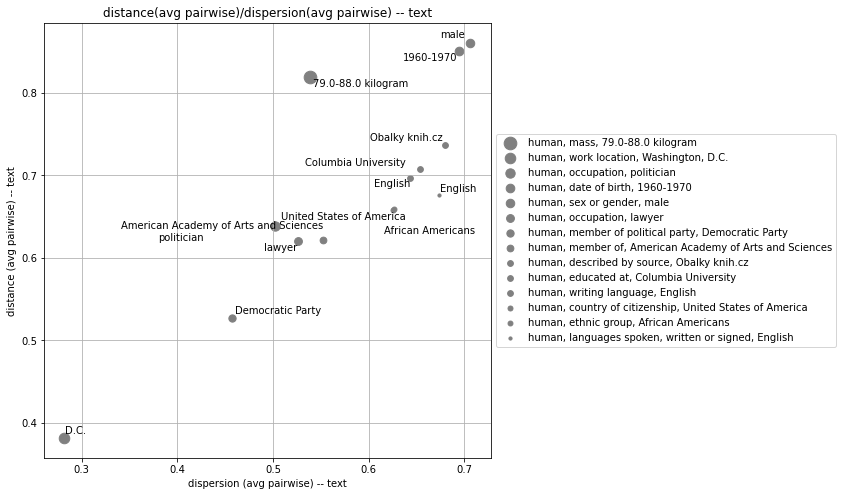

In [204]:
plot_surprise_metrics(ent_to_profile_labels_df[ent], "dispersion (avg pairwise) -- text", "distance (avg pairwise) -- text", "plab_label", "distance(avg pairwise)/dispersion(avg pairwise) -- text", "surprise_label")


### John Oliver (Q1701254)

In [205]:
ent = "Q1701254"

Retrieve profile-labels

In [206]:
%%time
ent_to_profile_labels_df[ent] = get_entity_profile_labels_df(profile_labels_df, ent)

CPU times: user 57.2 ms, sys: 5.43 s, total: 5.49 s
Wall time: 31.7 s


Annotate ground truth surprise using my judgment...

In [207]:
with pd.option_context("max_colwidth",None):
    display(list(ent_to_profile_labels_df[ent].loc[:,"plab_label"]))

['human, sex or gender, male',
 'human, country of citizenship, United States of America',
 'human, occupation, actor',
 'human, occupation, writer',
 'human, languages spoken, written or signed, English',
 'human, country of citizenship, United Kingdom',
 'human, given name, John',
 'human, occupation, journalist',
 'human, given name, William',
 'human, occupation, film actor',
 'human, occupation, screenwriter',
 'human, occupation, television actor',
 'human, occupation, television presenter',
 'human, occupation, television producer',
 'human, number of children, 0.0-2.0',
 'human, date of birth, 1970-1980',
 'human, work period (start), 1990-2000']

In [208]:
ent_to_profile_labels_df[ent].loc[:,"surprise_label"]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

/nas/home/nmklein/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Compute surprise metrics and add them to the table

In [209]:
ent_to_profile_labels_df[ent] = compute_surprise_metrics_for_df(ent, ent_to_profile_labels_df[ent], embedding_models["text"], "text", sample=10000, pairwise_sample=10000)


100%|███████████████████████████████████████████████████████████████████████████████████████| 17/17 [08:04<00:00, 28.48s/it]


In [ ]:
with pd.option_context("max_colwidth",None):
    display(ent_to_profile_labels_df[ent].sort_values("distance(avg pairwise)/dispersion(avg pairwise), text", ascending=False).loc[:,["id","plab_label", "distance (centroid), text", "distance (avg pairwise), text", "dispersion (centroid), text", "dispersion (avg pairwise), text", "distance(centroid)/dispersion(centroid), text", "distance(avg pairwise)/dispersion(centroid), text", "distance(avg pairwise)/dispersion(avg pairwise), text"]])
    

Consider metrics when sample is based on type only (e.g. compare Putin to random humans)

In [210]:
compute_surprise_metrics_sampling_by_type(ent, "Q5", embedding_models["text"], sample=10000, pairwise_sample=10000)

{'dispersion (centroid)': 0.5382804471581298,
 'distance (centroid)': 0.5824961364269257,
 'distance(centroid)/dispersion(centroid)': 1.0821424770344792,
 'distance (avg pairwise)': 0.8123410389079285,
 'distance(avg pairwise)/dispersion(centroid)': 1.5091409008012664,
 'dispersion (avg pairwise)': 0.7854635761337231,
 'distance(avg pairwise)/dispersion(avg pairwise)': 1.0342185985332433}

Plotting

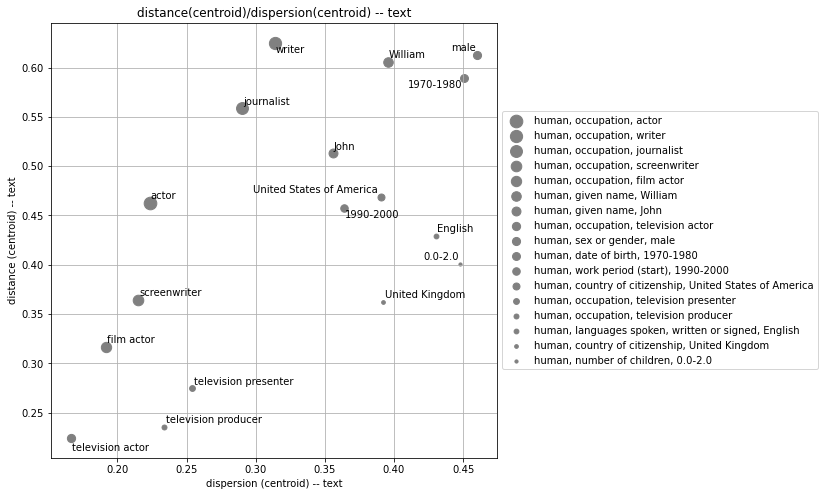

In [211]:
plot_surprise_metrics(ent_to_profile_labels_df[ent], "dispersion (centroid) -- text", "distance (centroid) -- text", "plab_label", "distance(centroid)/dispersion(centroid) -- text", "surprise_label")


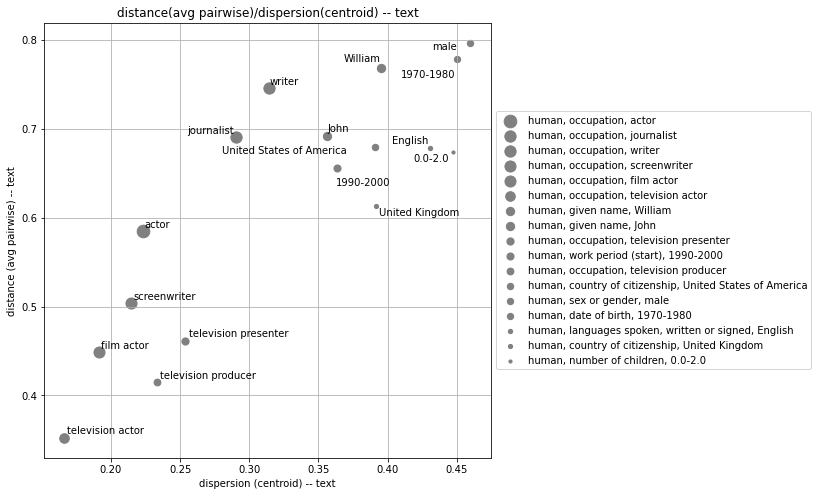

In [212]:
plot_surprise_metrics(ent_to_profile_labels_df[ent], "dispersion (centroid) -- text", "distance (avg pairwise) -- text", "plab_label", "distance(avg pairwise)/dispersion(centroid) -- text", "surprise_label")


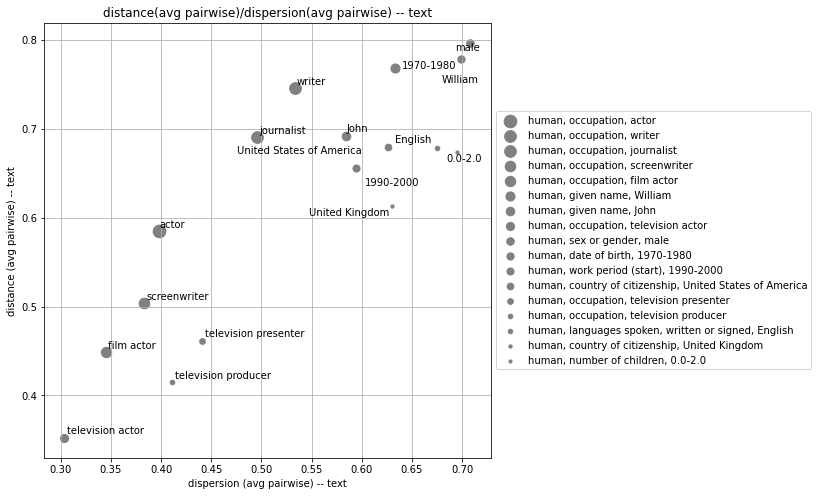

In [213]:
plot_surprise_metrics(ent_to_profile_labels_df[ent], "dispersion (avg pairwise) -- text", "distance (avg pairwise) -- text", "plab_label", "distance(avg pairwise)/dispersion(avg pairwise) -- text", "surprise_label")


### Roger Federer (Q1426)

In [214]:
ent = "Q1426"

Retrieve profile-labels

In [215]:
%%time
ent_to_profile_labels_df[ent] = get_entity_profile_labels_df(profile_labels_df, ent)

CPU times: user 55 ms, sys: 5.57 s, total: 5.62 s
Wall time: 33.8 s


Annotate ground truth surprise using my judgment...

In [216]:
with pd.option_context("max_colwidth",None):
    display(list(ent_to_profile_labels_df[ent].loc[:,"plab_label"]))

['human, sex or gender, male',
 'human, languages spoken, written or signed, English',
 'human, languages spoken, written or signed, German',
 'human, languages spoken, written or signed, French',
 'human, religion, Catholic Church',
 'human, described by source, Obalky knih.cz',
 'human, country of citizenship, Switzerland',
 'human, country of citizenship, South Africa',
 'human, native language, German',
 'human, occupation, tennis player',
 'human, sport, tennis',
 'human, participant in, 2004 Summer Olympics',
 'human, participant in, 2000 Summer Olympics',
 'human, given name, Roger',
 'human, height, 183.0-188.0 centimetre',
 'human, mass, 79.0-88.0 kilogram',
 'human, date of birth, 1980-1990',
 'human, work period (start), 1990-2000']

In [217]:
ent_to_profile_labels_df[ent].loc[:,"surprise_label"]=[0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0]

/nas/home/nmklein/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Compute surprise metrics and add them to the table

In [218]:
ent_to_profile_labels_df[ent] = compute_surprise_metrics_for_df(ent, ent_to_profile_labels_df[ent], embedding_models["text"], "text", sample=10000, pairwise_sample=10000)


100%|███████████████████████████████████████████████████████████████████████████████████████| 18/18 [09:38<00:00, 32.15s/it]


In [ ]:
with pd.option_context("max_colwidth",None):
    display(ent_to_profile_labels_df[ent].sort_values("distance(avg pairwise)/dispersion(avg pairwise)", ascending=False).loc[:,["id","plab_label", "distance (centroid)", "distance (avg pairwise)", "dispersion (centroid)", "dispersion (avg pairwise)", "distance(centroid)/dispersion(centroid)", "distance(avg pairwise)/dispersion(centroid)", "distance(avg pairwise)/dispersion(avg pairwise)"]])
    

Consider metrics when sample is based on type only (e.g. compare Putin to random humans)

In [219]:
compute_surprise_metrics_sampling_by_type(ent, "Q5", embedding_models["text"], sample=10000, pairwise_sample=10000)

{'dispersion (centroid)': 0.5382804471581298,
 'distance (centroid)': 0.4959227442741394,
 'distance(centroid)/dispersion(centroid)': 0.9213092299606657,
 'distance (avg pairwise)': 0.7712160350971778,
 'distance(avg pairwise)/dispersion(centroid)': 1.432740199219272,
 'dispersion (avg pairwise)': 0.7851301038801539,
 'distance(avg pairwise)/dispersion(avg pairwise)': 0.9822780088112633}

Plotting

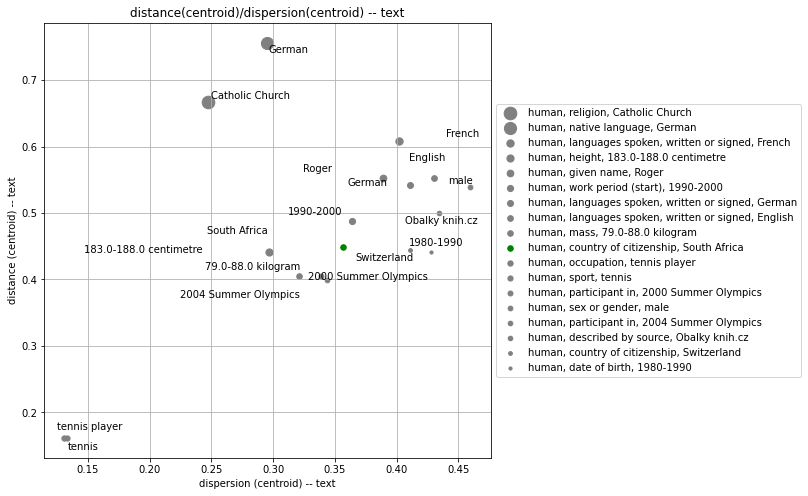

In [220]:
plot_surprise_metrics(ent_to_profile_labels_df[ent], "dispersion (centroid) -- text", "distance (centroid) -- text", "plab_label", "distance(centroid)/dispersion(centroid) -- text", "surprise_label")


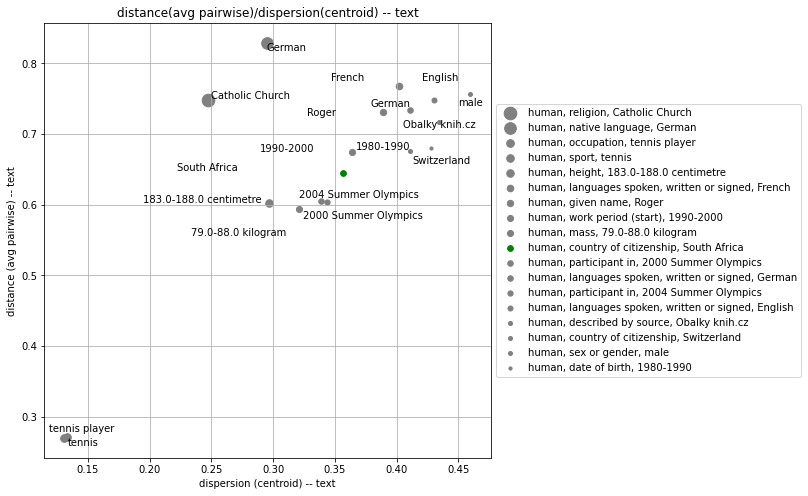

In [221]:
plot_surprise_metrics(ent_to_profile_labels_df[ent], "dispersion (centroid) -- text", "distance (avg pairwise) -- text", "plab_label", "distance(avg pairwise)/dispersion(centroid) -- text", "surprise_label")


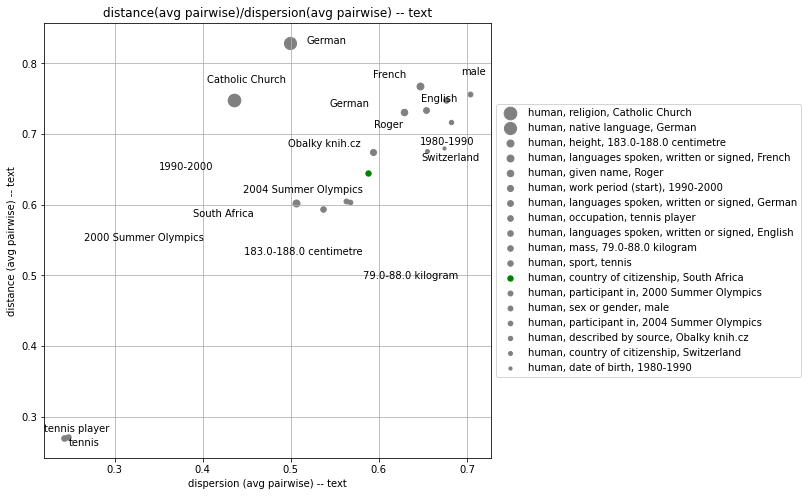

In [222]:
plot_surprise_metrics(ent_to_profile_labels_df[ent], "dispersion (avg pairwise) -- text", "distance (avg pairwise) -- text", "plab_label", "distance(avg pairwise)/dispersion(avg pairwise) -- text", "surprise_label")


### Apple, Inc. (Q312)

In [233]:
ent = "Q312"

Retrieve profile-labels

In [ ]:
%%time
ent_to_profile_labels_df[ent] = get_entity_profile_labels_df(profile_labels_df, ent)

Apple has multiple instance of values. Let's just use business...

In [225]:
ent_to_profile_labels_df[ent] = ent_to_profile_labels_df[ent].loc[["business," in label for label in ent_to_profile_labels_df[ent].loc[:,"plab_label"]]]


Annotate ground truth surprise using my judgment...

In [226]:
with pd.option_context("max_colwidth",None):
    display(list(ent_to_profile_labels_df[ent].loc[:,"plab_label"]))

['business, instance of, enterprise',
 'business, country, United States of America',
 'business, stock exchange, NASDAQ',
 'business, product or material produced, software',
 'business, industry, mobile phone industry',
 'business, instance of, brand',
 'business, industry, software industry',
 'business, part of, S&P 500',
 'business, industry, consumer electronics',
 'business, industry, information technology',
 'business, industry, electronics',
 'business, stock exchange, Tokyo Stock Exchange',
 'business, member of, Wi-Fi Alliance',
 'business, member of, SD Association',
 'business, country of origin, United States of America',
 'business, instance of, trademark',
 'business, product or material produced, computer hardware',
 'business, employees, 12533.0-9125654456456.0',
 'business, inception, 1970-1980']

In [227]:
ent_to_profile_labels_df[ent].loc[:,"surprise_label"]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

Compute surprise metrics and add them to the table

In [228]:
ent_to_profile_labels_df[ent] = compute_surprise_metrics_for_df(ent, ent_to_profile_labels_df[ent], embedding_models["text"], "text", sample=10000, pairwise_sample=10000)


100%|███████████████████████████████████████████████████████████████████████████████████████| 19/19 [11:45<00:00, 37.14s/it]


In [ ]:
with pd.option_context("max_colwidth",None):
    display(ent_to_profile_labels_df[ent].sort_values("distance(avg pairwise)/dispersion(avg pairwise)", ascending=False).loc[:,["id","plab_label", "distance (centroid)", "distance (avg pairwise)", "dispersion (centroid)", "dispersion (avg pairwise)", "distance(centroid)/dispersion(centroid)", "distance(avg pairwise)/dispersion(centroid)", "distance(avg pairwise)/dispersion(avg pairwise)"]])
    

Consider metrics when sample is based on type only (e.g. compare Putin to random humans)

In [229]:
compute_surprise_metrics_sampling_by_type(ent, "Q4830453", embedding_models["text"], sample=10000, pairwise_sample=10000)

{'dispersion (centroid)': 0.38872738708236804,
 'distance (centroid)': 0.531410425901413,
 'distance(centroid)/dispersion(centroid)': 1.3670516756999465,
 'distance (avg pairwise)': 0.7180318227545368,
 'distance(avg pairwise)/dispersion(centroid)': 1.8471346414354695,
 'dispersion (avg pairwise)': 0.6259988872248999,
 'distance(avg pairwise)/dispersion(avg pairwise)': 1.1470177302353137}

Plotting

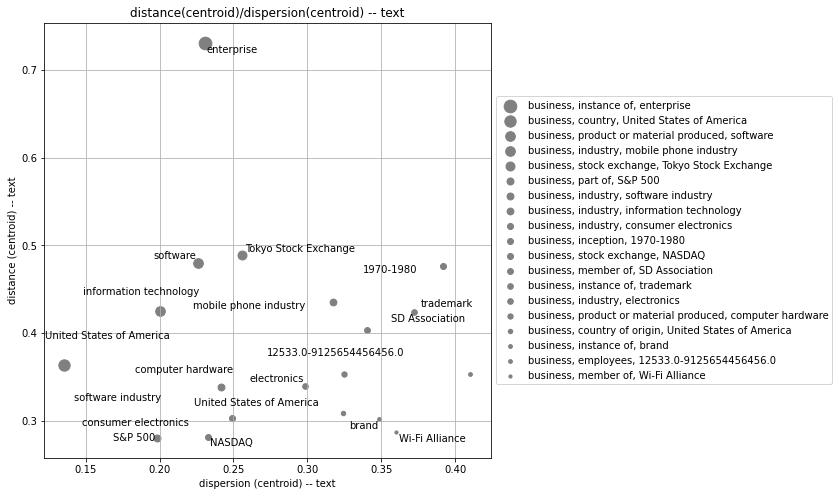

In [230]:
plot_surprise_metrics(ent_to_profile_labels_df[ent], "dispersion (centroid) -- text", "distance (centroid) -- text", "plab_label", "distance(centroid)/dispersion(centroid) -- text", "surprise_label")


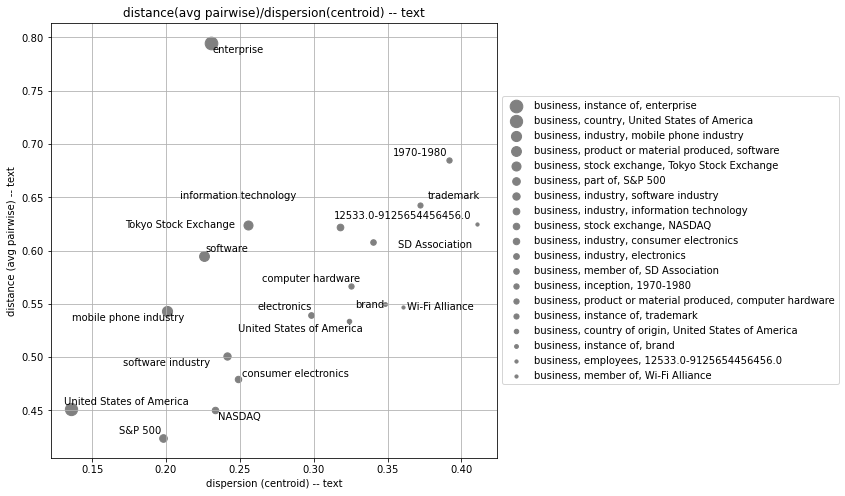

In [231]:
plot_surprise_metrics(ent_to_profile_labels_df[ent], "dispersion (centroid) -- text", "distance (avg pairwise) -- text", "plab_label", "distance(avg pairwise)/dispersion(centroid) -- text", "surprise_label")


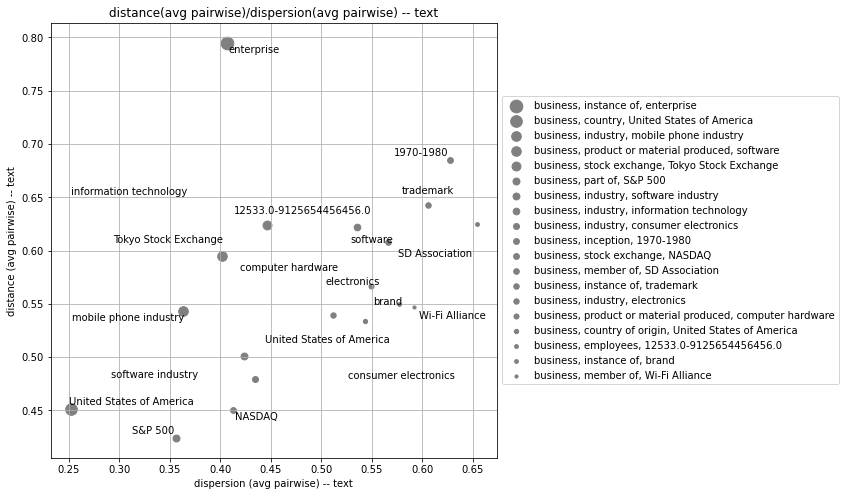

In [232]:
plot_surprise_metrics(ent_to_profile_labels_df[ent], "dispersion (avg pairwise) -- text", "distance (avg pairwise) -- text", "plab_label", "distance(avg pairwise)/dispersion(avg pairwise) -- text", "surprise_label")


## Try computing suprise(fact2 | fact1)

In [ ]:
def compute_label_dists_and_disps(labels_list, embedding_dict, 
                                  label_to_ents_dict, sample=10000, pairwise_sample=10000):
    label_to_sample = {}
    for l in labels_list:
        sample_ents = get_entities_with_profile_label(l, limit=sample, label_to_ents_dict=label_to_ents_dict)
        sample_embeds = np.array([embedding_dict[e] for e in sample_ents])
        label_to_sample[l] = sample_embeds

    disps = {}
    for l, sample_embeds in label_to_sample.items():
        # avg pairwise dist within sample
        sample_dists = []
        for i in range(pairwise_sample):
            e1, e2 = sample_embeds[np.random.choice(sample_embeds.shape[0], size=2, replace=False), :]
            sample_dists.append(distance.cosine(e1, e2))
        avg_sample_to_sample = np.mean(sample_dists)
        disps[l] = avg_sample_to_sample
        
    dists = {}
    for l1, sample_embeds1 in label_to_sample.items():
        for l2, sample_embeds2 in label_to_sample.items():
            # skip if labels are same
            if l1==l2:
                continue
            # init first level of dictionary
            if l1 not in dists:
                dists[l1] = {}
            if l2 not in dists:
                dists[l2] = {}
            # we may have already computed this. If we have, then l2 will be in l1's dict and vice versa
            if l2 not in dists[l1]:
                TODO
                
                
                       

### Putin again

In [268]:
ent="Q7747"
labels_list = list(ent_to_profile_labels_df[ent]["id"])

In [270]:
label_dists, label_disps = compute_label_dists_and_disps(labels_list, embedding_models["text"], 
                                                         human_label_to_ents_dict, sample=10000, pairwise_sample=10000)


id  \
368140               Q5_P21_Q6581097   
368143                Q5_P106_Q82955   
368151                Q5_P1412_Q1860   
368154                 Q5_P1412_Q188   
368181                Q5_P106_Q40348   
368186                 Q5_P27_Q15180   
368191                Q5_P106_Q47064   
368194                   Q5_P27_Q159   
368211            Q5_P1343_Q67311526   
368260                Q5_P1412_Q7737   
368267               Q5_P106_Q185351   
368391                Q5_P1412_Q9027   
368407                Q5_P6886_Q1860   
368457                Q5_P102_Q79854   
368462                 Q5_P103_Q7737   
368527               Q5_P410_Q104680   
368578              Q5_P735_Q2253934   
533404  Q5_P2048_1.78-170.0__Q174728   
533411    Q5_P2067_73.0-79.0__Q11570   
605956             Q5_P569_1950-1960   
606011            Q5_P2031_1970-1980   

                                               plab_label  \
368140                         human, sex or gender, male   
368143                      human, occupation, politician   
368151  human, languages spoken, written or signed, En...   
368154  human, languages spoken, written or signed, Ge...   
368181                          human, occupation, lawyer   
368186        human, country of citizenship, Soviet Union   
368191              human, occupation, military personnel   
368194              human, country of citizenship, Russia   
368211         human, described by source, Obalky knih.cz   
368260  human, languages spoken, written or signed, Ru...   
368267                          human, occupation, jurist   
368391  human, languages spoken, written or signed, Sw...   
368407                   human, writing language, English   
368457  human, member of political party, Communist Pa...   
368462                    human, native language, Russian   
368527                      human, military rank, colonel   
368578                        human, given name, Vladimir   
533404               human, height, 1.78-170.0 centimetre   
533411                    human, mass, 73.0-79.0 kilogram   
605956                    human, date of birth, 1950-1960   
606011              human, work period (start), 1970-1980   

                      support  distinctiveness  surprise_label  \
368140     0.5779681838190067         0.175249               0   
368143    0.06521513442634484         0.197663               0   
368151   0.025629212807962157         0.263496               0   
368154   0.019660259037766203         0.354203               1   
368181   0.008697859135084906         0.243468               2   
368186   0.007849251764756461         0.416726               0   
368191  0.0069975909712475005         0.243525               0   
368194  0.0068761868655902655         0.392806               0   
368211   0.005793687279634449         0.228881               0   
368260   0.003758763935212711         0.414013               0   
368267  0.0035635891255142577         0.227005               0   
368391  0.0017507107147794964         0.430369               2   
368407  0.0016918407158591868         0.338339               0   
368457   0.001418009725030693         0.488062               0   
368462  0.0013794144560289965         0.468172               0   
368527  0.0011639649164119296         0.237437               1   
368578  0.0010492783417518246         0.335910               0   
533404  0.0032257583848221906         0.311804               0   
533411  0.0021957776775712143         0.336291               0   
605956     0.0473374638413627         0.128692               0   
606011  0.0020272287180068426         0.242333               0   

        dispersion (centroid) -- text  distance (centroid) -- text  \
368140                       0.459792                     0.878898   
368143                       0.295231                     0.667556   
368151                       0.430575                     0.664019   
368154                       0.410927                     0.644577   
368181 

## Original text embeddings

In [16]:
orig_embed_subsets_dir = "/data02/profiling/dwd-v3.class_subsets"

In [17]:
orig_embed_dict = {}
for filename in glob.glob(f"{orig_embed_subsets_dir}/*"):
    print(f"loading from file {filename}")
    embedding_df = pd.read_csv(filename, sep='\t')
    for _, row in tqdm(embedding_df.iterrows()):
        ent = row["node1"]
        embed = np.float32(row["node2"].split(','))
        orig_embed_dict[ent] = embed

loading from file /data02/profiling/dwd-v3.class_subsets/Q5.tsv.gz


8902387it [33:05, 4482.60it/s]


loading from file /data02/profiling/dwd-v3.class_subsets/Q3624078.tsv.gz


403it [00:07, 50.99it/s]


loading from file /data02/profiling/dwd-v3.class_subsets/Q532.tsv.gz


276515it [01:02, 4428.38it/s]


loading from file /data02/profiling/dwd-v3.class_subsets/Q23442.tsv.gz


148102it [00:34, 4303.22it/s]


loading from file /data02/profiling/dwd-v3.class_subsets/Q783794.tsv.gz


9518it [00:02, 4208.61it/s]


In [18]:
ent_to_profile_labels_df = {}

### Putin (Q7747)

In [21]:
ent = "Q7747"

Retrieve profile-labels

In [24]:
%%time
ent_to_profile_labels_df[ent] = get_entity_profile_labels_df(profile_labels_df, ent, human_ent_to_labels_dict)

CPU times: user 69.9 ms, sys: 39.1 ms, total: 109 ms
Wall time: 106 ms


In [25]:
ent_to_profile_labels_df[ent].loc[:,"surprise_label"]=[0,0,0,1,2,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0]

/nas/home/nmklein/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Compute surprise metrics and add them to the table

In [28]:
ent_to_profile_labels_df[ent] = compute_surprise_metrics_for_df(ent, ent_to_profile_labels_df[ent], orig_embed_dict, "text", sample=10000, pairwise_sample=10000, label_to_ents_dict=human_label_to_ents_dict)


100%|███████████████████████████████████████████████████████████████████████████████████████| 21/21 [01:25<00:00,  4.05s/it]


In [ ]:
with pd.option_context("max_colwidth",None):
    display(ent_to_profile_labels_df[ent].sort_values("distance(avg pairwise)/dispersion(avg pairwise)", ascending=False).loc[:,["id","plab_label", "distance (centroid)", "distance (avg pairwise)", "dispersion (centroid)", "dispersion (avg pairwise)", "distance(centroid)/dispersion(centroid)", "distance(avg pairwise)/dispersion(centroid)", "distance(avg pairwise)/dispersion(avg pairwise)"]])
    

Plotting

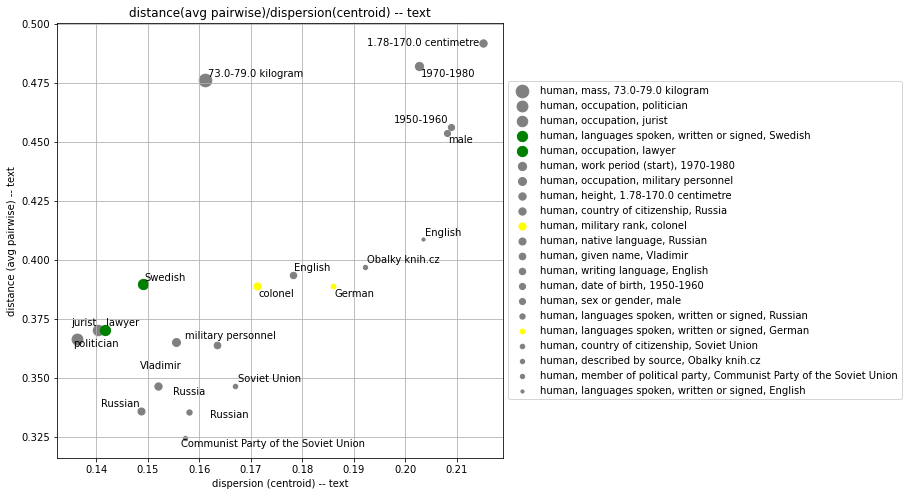

In [29]:
plot_surprise_metrics(ent_to_profile_labels_df[ent], "dispersion (centroid) -- text", "distance (avg pairwise) -- text", "plab_label", "distance(avg pairwise)/dispersion(centroid) -- text", "surprise_label")


### Obama (Q76)

In [30]:
ent = "Q76"

Retrieve profile-labels

In [32]:
%%time
ent_to_profile_labels_df[ent] = get_entity_profile_labels_df(profile_labels_df, ent, human_ent_to_labels_dict)

CPU times: user 47 ms, sys: 35.1 ms, total: 82.1 ms
Wall time: 80.1 ms


Annotate ground truth surprise using my judgment...

In [33]:
ent_to_profile_labels_df[ent].loc[:,"surprise_label"]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0]

Compute surprise metrics and add them to the table

In [34]:
ent_to_profile_labels_df[ent] = compute_surprise_metrics_for_df(ent, ent_to_profile_labels_df[ent], orig_embed_dict, "text", sample=10000, pairwise_sample=10000, label_to_ents_dict=human_label_to_ents_dict)


100%|███████████████████████████████████████████████████████████████████████████████████████| 14/14 [01:00<00:00,  4.30s/it]


Plotting

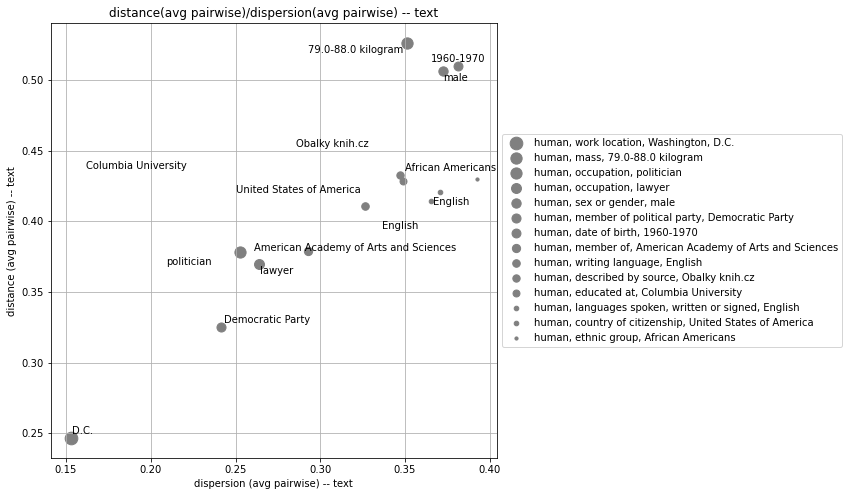

In [36]:
plot_surprise_metrics(ent_to_profile_labels_df[ent], "dispersion (avg pairwise) -- text", "distance (avg pairwise) -- text", "plab_label", "distance(avg pairwise)/dispersion(avg pairwise) -- text", "surprise_label")


### John Oliver (Q1701254)

In [37]:
ent = "Q1701254"

Retrieve profile-labels

In [38]:
%%time
ent_to_profile_labels_df[ent] = get_entity_profile_labels_df(profile_labels_df, ent, human_ent_to_labels_dict)

CPU times: user 56.2 ms, sys: 22.1 ms, total: 78.2 ms
Wall time: 76.6 ms


Annotate ground truth surprise using my judgment...

In [39]:
ent_to_profile_labels_df[ent].loc[:,"surprise_label"]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

/nas/home/nmklein/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Compute surprise metrics and add them to the table

In [40]:
ent_to_profile_labels_df[ent] = compute_surprise_metrics_for_df(ent, ent_to_profile_labels_df[ent], orig_embed_dict, "text", sample=10000, pairwise_sample=10000, label_to_ents_dict=human_label_to_ents_dict)


100%|███████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:16<00:00,  4.49s/it]


Plotting

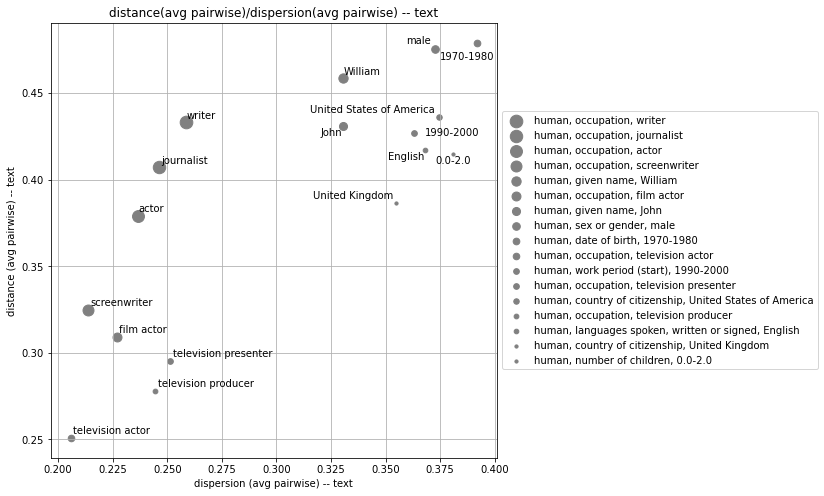

In [41]:
plot_surprise_metrics(ent_to_profile_labels_df[ent], "dispersion (avg pairwise) -- text", "distance (avg pairwise) -- text", "plab_label", "distance(avg pairwise)/dispersion(avg pairwise) -- text", "surprise_label")


### Roger Federer (Q1426)

In [42]:
ent = "Q1426"

Retrieve profile-labels

In [43]:
%%time
ent_to_profile_labels_df[ent] = get_entity_profile_labels_df(profile_labels_df, ent, human_ent_to_labels_dict)

CPU times: user 22.9 ms, sys: 58.2 ms, total: 81.1 ms
Wall time: 80.5 ms


Annotate ground truth surprise using my judgment...

In [44]:
ent_to_profile_labels_df[ent].loc[:,"surprise_label"]=[0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0]

Compute surprise metrics and add them to the table

In [45]:
ent_to_profile_labels_df[ent] = compute_surprise_metrics_for_df(ent, ent_to_profile_labels_df[ent], orig_embed_dict, "text", sample=10000, pairwise_sample=10000, label_to_ents_dict=human_label_to_ents_dict)


100%|███████████████████████████████████████████████████████████████████████████████████████| 18/18 [01:11<00:00,  3.98s/it]


Plotting

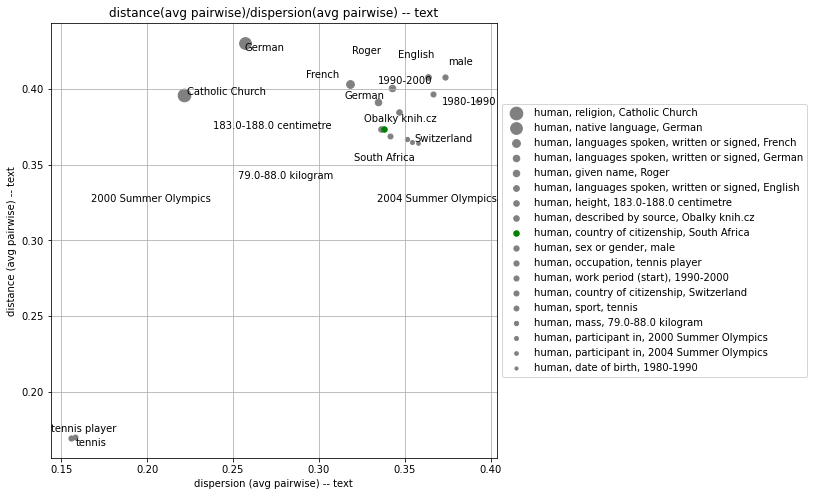

In [46]:
plot_surprise_metrics(ent_to_profile_labels_df[ent], "dispersion (avg pairwise) -- text", "distance (avg pairwise) -- text", "plab_label", "distance(avg pairwise)/dispersion(avg pairwise) -- text", "surprise_label")


### Apple, Inc. (Q312)

In [233]:
ent = "Q312"

Retrieve profile-labels

In [ ]:
%%time
ent_to_profile_labels_df[ent] = get_entity_profile_labels_df(profile_labels_df, ent, human_ent_to_labels_dict)

Apple has multiple instance of values. Let's just use business...

In [225]:
ent_to_profile_labels_df[ent] = ent_to_profile_labels_df[ent].loc[["business," in label for label in ent_to_profile_labels_df[ent].loc[:,"plab_label"]]]


Annotate ground truth surprise using my judgment...

In [226]:
with pd.option_context("max_colwidth",None):
    display(list(ent_to_profile_labels_df[ent].loc[:,"plab_label"]))

['business, instance of, enterprise',
 'business, country, United States of America',
 'business, stock exchange, NASDAQ',
 'business, product or material produced, software',
 'business, industry, mobile phone industry',
 'business, instance of, brand',
 'business, industry, software industry',
 'business, part of, S&P 500',
 'business, industry, consumer electronics',
 'business, industry, information technology',
 'business, industry, electronics',
 'business, stock exchange, Tokyo Stock Exchange',
 'business, member of, Wi-Fi Alliance',
 'business, member of, SD Association',
 'business, country of origin, United States of America',
 'business, instance of, trademark',
 'business, product or material produced, computer hardware',
 'business, employees, 12533.0-9125654456456.0',
 'business, inception, 1970-1980']

In [227]:
ent_to_profile_labels_df[ent].loc[:,"surprise_label"]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

Compute surprise metrics and add them to the table

In [228]:
ent_to_profile_labels_df[ent] = compute_surprise_metrics_for_df(ent, ent_to_profile_labels_df[ent], orig_embed_dict, "text", sample=10000, pairwise_sample=10000, label_to_ents_dict=human_label_to_ents_dict)


100%|███████████████████████████████████████████████████████████████████████████████████████| 19/19 [11:45<00:00, 37.14s/it]


Plotting

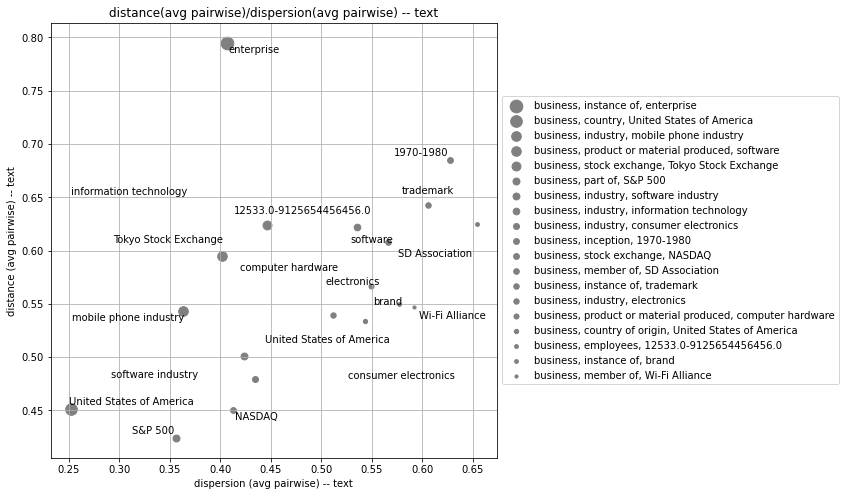

In [232]:
plot_surprise_metrics(ent_to_profile_labels_df[ent], "dispersion (avg pairwise) -- text", "distance (avg pairwise) -- text", "plab_label", "distance(avg pairwise)/dispersion(avg pairwise) -- text", "surprise_label")
